# Python preprocessing - Nicaragua Hurricanes
#### Caio Iglesias - MIT 15.083 - Integer Optimization 

## 1. Get Past Hurricanes

In [24]:
# -----------------------------------------------------------------------------
# Full Nicaragua‑only Hurricane Track Extraction + Export
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
from shapely.geometry import Point, LineString, shape

import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
from geopy.distance import geodesic

# 1) Load & clean HURDAT2
def _parse_coord(x):
    if pd.isna(x): return np.nan
    val, hemi = float(x[:-1]), x[-1]
    return val if hemi in ("N","E") else -val

hurdat = (
    pd.read_csv("data/hurdat2.csv", skipinitialspace=True)
      .rename(columns=str.strip)
)
hurdat["time"] = hurdat["time"].astype(str).str.zfill(4)
hurdat["datetime"] = pd.to_datetime(
    hurdat["date"].astype(str)+hurdat["time"],
    format="%Y%m%d%H%M", errors="coerce"
)


hurdat["lat"] = hurdat["latitude"].apply(_parse_coord)
hurdat["lon"] = hurdat["longitude"].apply(_parse_coord)
hurdat.replace(-999, np.nan, inplace=True)
hurdat.dropna(subset=["lat","lon"], inplace=True)

gdf_tracks = gpd.GeoDataFrame(
    hurdat,
    geometry=gpd.points_from_xy(hurdat.lon, hurdat.lat),
    crs="EPSG:4326"
)

# 2) Fetch Nicaragua polygon (robust, no Fiona.path)
countries_url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
countries = requests.get(countries_url).json()

nic_poly = None
for feat in countries["features"]:
    props = feat.get("properties",{})
    if any(isinstance(v,str) and v.strip().lower()=="nicaragua"
           for v in props.values()):
        nic_poly = shape(feat["geometry"])
        break
if nic_poly is None:
    raise RuntimeError("Could not find Nicaragua in GeoJSON.")

# 3) Filter storms whose track intersects Nicaragua
storms_in_nic = (
    gdf_tracks
      .groupby("storm_id")["geometry"]
      .apply(lambda pts: pts.unary_union.intersects(nic_poly))
)
candidate_ids = storms_in_nic[storms_in_nic].index.tolist()
print(f"{len(candidate_ids)} storms intersect Nicaragua.")

# 4) Build scenarios + full‐track GeoJSON
scenario_list, line_features = [], []
n = len(candidate_ids)
for sid in candidate_ids:
    sub = gdf_tracks[gdf_tracks["storm_id"]==sid].sort_values("datetime")
    line = LineString(sub.geometry.to_list())
    scenario_list.append({
        "scenario_id": sid,
        "probability": 1.0/n,
        "max_wind_knots": float(sub["maximum_sustained_wind_knots"].max()),
        "min_pressure_mb": float(sub["central_pressure_mb"].min()),
        "track": [[p.x,p.y] for p in sub.geometry],
    })
    line_features.append({
        "type":"Feature",
        "properties":{"storm_id":sid},
        "geometry":line.__geo_interface__,
    })

# 5) Write outputs
with open("data/hurricane_scenarios.json","w") as fp:
    json.dump(scenario_list, fp, indent=2)

gpd.GeoDataFrame.from_features(line_features, crs="EPSG:4326") \
    .to_file("data/hurricane_tracks.geojson", driver="GeoJSON")

print("✓ Written data/hurricane_scenarios.json")
print("✓ Written data/hurricane_tracks.geojson")

42 storms intersect Nicaragua.
✓ Written data/hurricane_scenarios.json
✓ Written data/hurricane_tracks.geojson


In [44]:
list_hurric = list(storms_in_nic[storms_in_nic == True].index)

In [51]:
gdf_tracks.query("storm_id.isin(@list_hurric)").date.unique()

array([18760929, 18760930, 18761001, 18761002, 18761003, 18761004,
       18761005, 18901031, 18901101, 19061008, 19061009, 19061010,
       19061011, 19061012, 19061013, 19061014, 19061015, 19061016,
       19061017, 19061018, 19061019, 19061020, 19061021, 19061022,
       19061023, 19081014, 19081015, 19081016, 19081017, 19081018,
       19081019, 19090615, 19090616, 19090617, 19090618, 19090619,
       19110903, 19110904, 19110905, 19110906, 19110907, 19110908,
       19110909, 19110910, 19110911, 19110912, 19161111, 19161112,
       19161113, 19161114, 19161115, 19161116, 19331115, 19331116,
       19331117, 19351018, 19351019, 19351020, 19351021, 19351022,
       19351023, 19351024, 19351025, 19351026, 19351027, 19400918,
       19400919, 19400920, 19400921, 19400922, 19400923, 19400924,
       19400925, 19401020, 19401021, 19401022, 19401023, 19401024,
       19491103, 19491104, 19491105, 19530525, 19530526, 19530527,
       19530528, 19530529, 19530530, 19530531, 19530601, 19530

In [25]:
indices_nic = pd.DataFrame(storms_in_nic).query("geometry == True").reset_index().storm_id.unique()

In [26]:
print("Scenarios:", len(scenario_list), "storms")
# or, if you wrote JSON:
import json
with open("data/hurricane_scenarios.json") as f:
    scenarios = json.load(f)
print("Scenarios in file:", len(scenarios))

Scenarios: 42 storms
Scenarios in file: 42


## 2. Plot Past Hurricanes and Heatmap

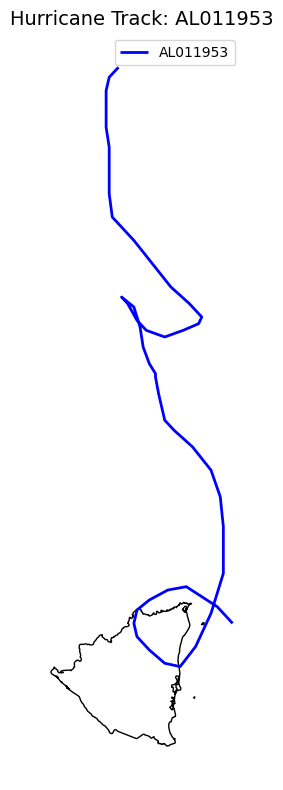

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# 1) Pick a built‐in scenario from memory:
#    assume `scenario_list` is now non‐empty
sc = scenario_list[1]  
coords = sc["track"]    # list of [lon, lat]

# 2) Turn it into a LineString GeoDataFrame
line = LineString([(lon, lat) for lon, lat in coords])
gdf_line = gpd.GeoDataFrame([{"storm_id": sc["scenario_id"], "geometry": line}], crs="EPSG:4326")

# 3) Use the Nicaragua polygon you already have in `nic_poly`
gdf_nic = gpd.GeoDataFrame(geometry=[nic_poly], crs="EPSG:4326")

# 4) Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_nic.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
gdf_line.plot(ax=ax, color="blue", linewidth=2, label=sc["scenario_id"])

ax.set_title(f"Hurricane Track: {sc['scenario_id']}", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

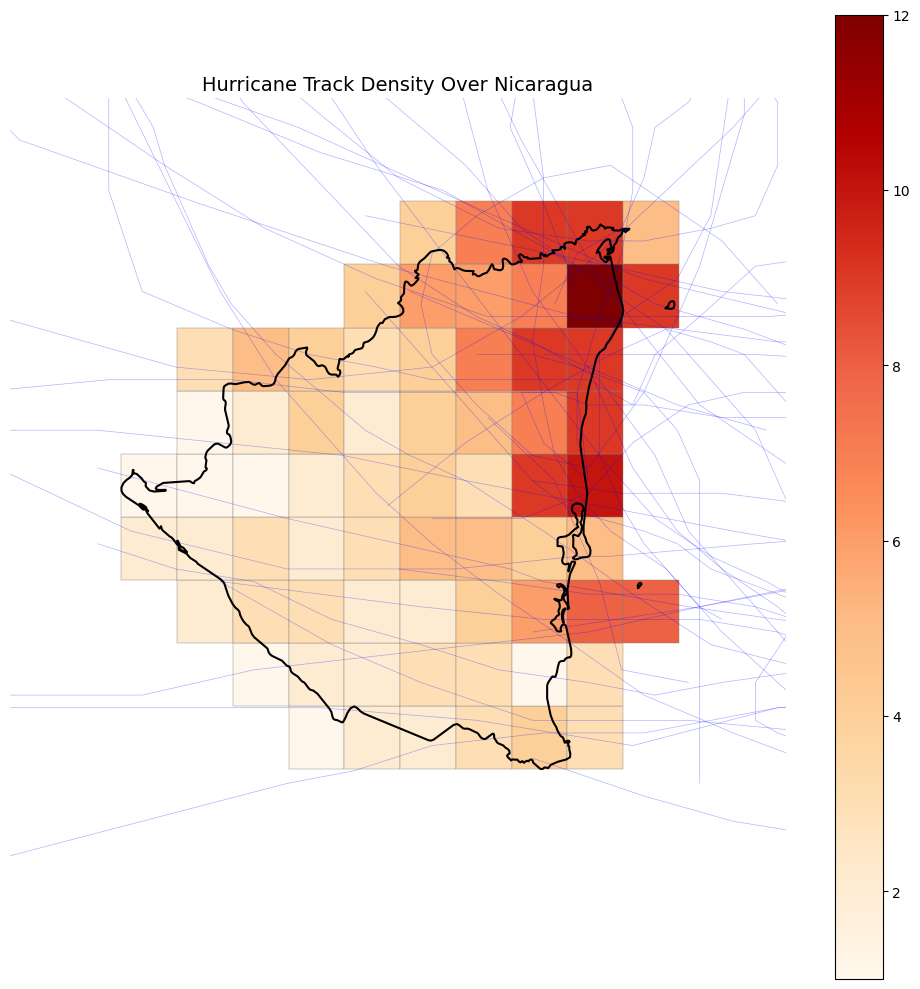

In [17]:
import geopandas as gpd
from shapely.geometry import LineString, box
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert all hurricane tracks to a GeoDataFrame
track_lines = []
for sc in scenario_list:
    coords = sc["track"]
    line = LineString([(lon, lat) for lon, lat in coords])
    track_lines.append({"storm_id": sc["scenario_id"], "geometry": line})
gdf_tracks = gpd.GeoDataFrame(track_lines, crs="EPSG:4326")

# Step 2: Create a grid over Nicaragua's bounding box
minx, miny, maxx, maxy = gpd.GeoSeries([nic_poly]).total_bounds
grid_size = 0.5  # degrees
xs = np.arange(minx, maxx, grid_size)
ys = np.arange(miny, maxy, grid_size)
grid_cells = []
for x in xs:
    for y in ys:
        cell = box(x, y, x + grid_size, y + grid_size)
        if nic_poly.intersects(cell):
            grid_cells.append(cell)
grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:4326")

# Step 3: Count how many hurricane tracks intersect each cell
grid["count"] = grid.geometry.apply(
    lambda cell: gdf_tracks.intersects(cell).sum()
)

# Step 4: Plot the density
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoDataFrame(geometry=[nic_poly], crs="EPSG:4326").boundary.plot(ax=ax, color="black")
grid.plot(ax=ax, column="count", cmap="OrRd", legend=True, edgecolor="grey", linewidth=0.3)
gdf_tracks.plot(ax=ax, color="blue", linewidth=0.5, alpha=0.3)

minx, miny, maxx, maxy = gdf_nic.total_bounds
ax.set_xlim(minx - 1, maxx + 1)
ax.set_ylim(miny - 1, maxy + 1)

ax.set_title("Hurricane Track Density Over Nicaragua", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# (Optional) Save top N cells with highest density
top_cells = grid.sort_values("count", ascending=False).head(10)
top_cells.to_file("data/hurricane_density_hotspots.geojson", driver="GeoJSON")


<ipython-input-18-a6fd8fa3bf57>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


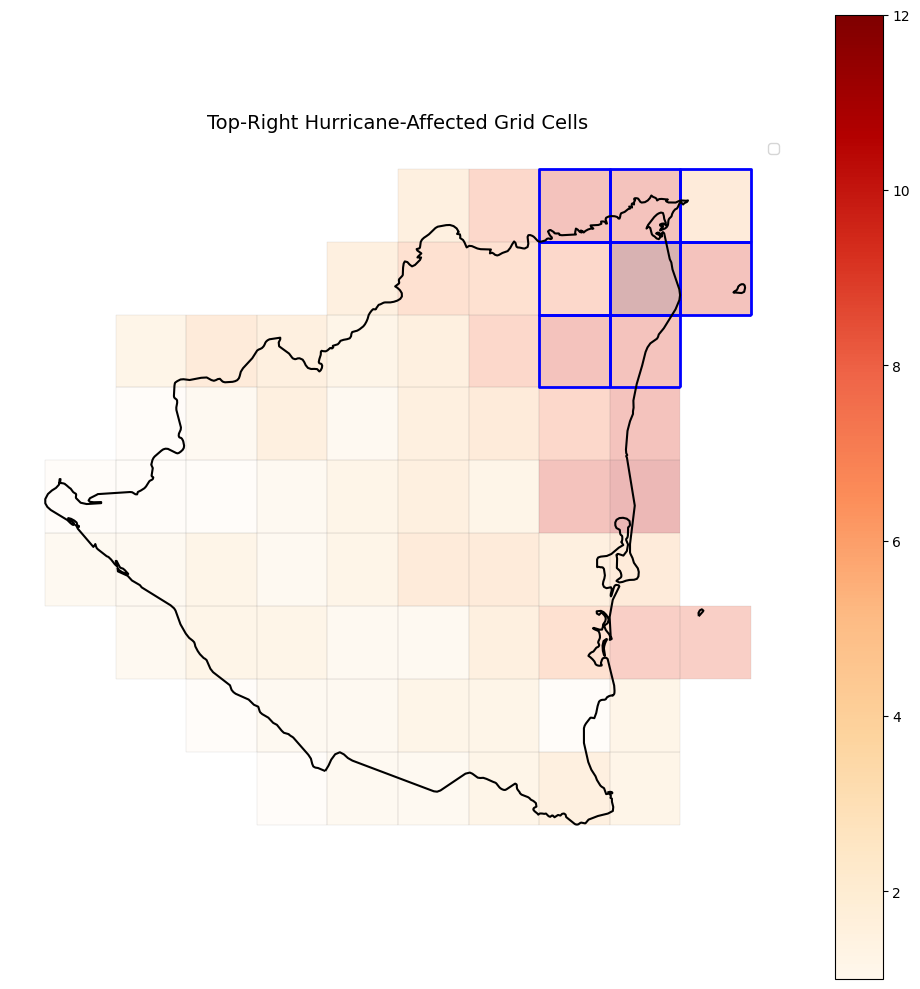

In [18]:
# Compute bounds
grid["xmax"] = grid.geometry.bounds.maxx
grid["ymax"] = grid.geometry.bounds.maxy

# Define thresholds for top 20% longitude and latitude
x_thresh = grid["xmax"].quantile(0.80)
y_thresh = grid["ymax"].quantile(0.80)

# Filter: cells in the top-right corner of Nicaragua
top_right_cells = grid[(grid["xmax"] >= x_thresh) & (grid["ymax"] >= y_thresh)]
top_right_cells = top_right_cells[top_right_cells["count"] > 0]

# Plot to verify
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoDataFrame(geometry=[nic_poly], crs="EPSG:4326").boundary.plot(ax=ax, edgecolor="black")
grid.plot(ax=ax, column="count", cmap="OrRd", legend=True, edgecolor="grey", linewidth=0.3, alpha=0.3)
top_right_cells.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2, label="Top-right cells")

ax.set_title("Top-Right Hurricane-Affected Grid Cells", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


## 3. Get Nicaragua Roads

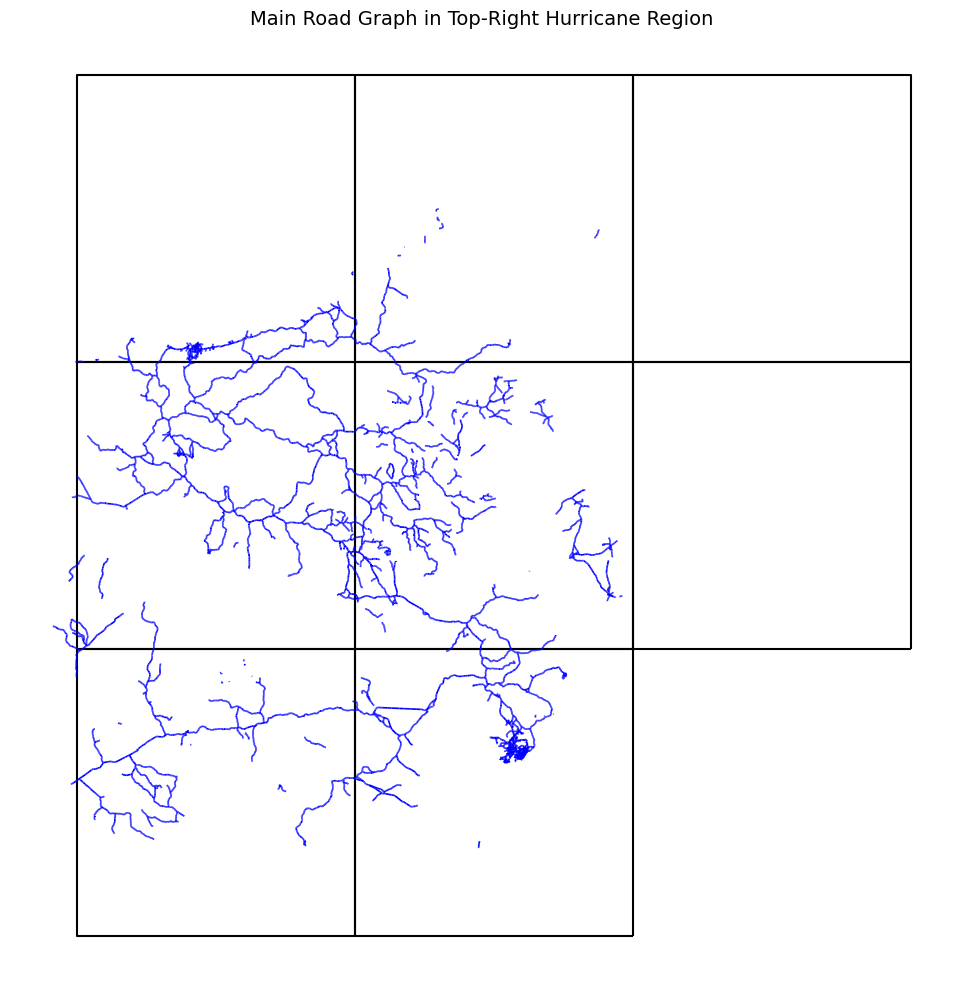

In [19]:
# ---------------------------
# 2. Query OSM Overpass for all highways in Nicaragua
# ---------------------------
overpass_url = "https://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:60];
area["ISO3166-1"="NI"][admin_level=2];
way(area)["highway"];
out geom;
"""
resp = requests.post(overpass_url, data={"data": overpass_query})
osm_data = resp.json()["elements"]

# ---------------------------
# 1. Parse OSM elements 
# ---------------------------
from shapely.geometry import LineString

# Option B: include all highways except very minor ways
exclude = {
    "footway",
    "path",
    "cycleway",
    "track",
    "pedestrian",
    "steps",
    "bus_stop",
    "platform"
}

segments = []
for elem in osm_data:
    if elem["type"] != "way":
        continue
    tags = elem.get("tags", {})
    hwy = tags.get("highway")
    # skip if it's in the exclude list or missing
    if hwy is None or hwy in exclude:
        continue
    coords = [(pt["lon"], pt["lat"]) for pt in elem["geometry"]]
    if len(coords) < 2:
        continue
    segments.append({
        "osm_id":   elem["id"],
        "highway":  hwy,
        "geometry": LineString(coords),
    })

roads_gdf = gpd.GeoDataFrame(segments, crs="EPSG:4326")


# ---------------------------
# 2. Clip to top-right hurricane region
# ---------------------------
region_union = top_right_cells.unary_union
roads_clipped = roads_gdf[roads_gdf.geometry.intersects(region_union)]

# ---------------------------
# 3. Build graph from clipped roads (handles MultiLineString)
# ---------------------------
import networkx as nx
from shapely.geometry import LineString, MultiLineString
from geopy.distance import geodesic

G = nx.Graph()

for _, row in roads_clipped.iterrows():
    geom = row.geometry
    if geom is None:
        continue

    # Support both LineString and MultiLineString
    lines = [geom] if isinstance(geom, LineString) else list(geom)

    for line in lines:
        coords = list(line.coords)
        for u, v in zip(coords[:-1], coords[1:]):
            if u == v:
                continue
            u_latlon, v_latlon = (u[1], u[0]), (v[1], v[0])
            dist_km = geodesic(u_latlon, v_latlon).km
            G.add_node(u, pos=u)
            G.add_node(v, pos=v)
            G.add_edge(u, v, geometry=LineString([u, v]), length_km=dist_km)

# ---------------------------
# 4. Optional: visualize
# ---------------------------
edges = [
    {"geometry": data["geometry"], "length_km": data["length_km"]}
    for u, v, data in G.edges(data=True)
]
graph_gdf = gpd.GeoDataFrame(edges, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))
top_right_cells.boundary.plot(ax=ax, edgecolor="black")
graph_gdf.plot(ax=ax, color="blue", linewidth=1.2)
ax.set_title("Main Road Graph in Top-Right Hurricane Region", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

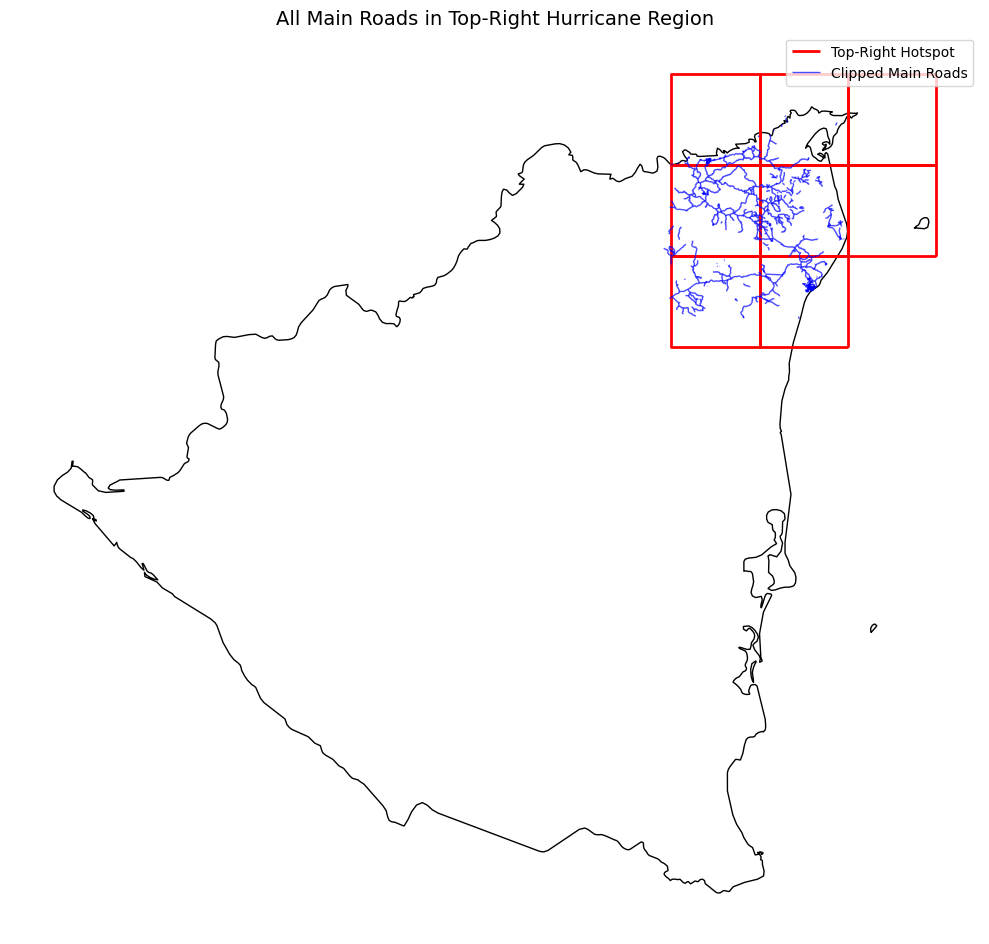

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Explode in case there are any MultiLineStrings
roads_plot = roads_clipped.explode(index_parts=False).reset_index(drop=True)

# 2) Prepare Nicaragua outline & top‑right cells
gdf_nic_outline = gpd.GeoDataFrame(geometry=[nic_poly], crs="EPSG:4326")
gdf_cells = top_right_cells

# 3) Plot everything together
fig, ax = plt.subplots(figsize=(10, 10))
gdf_nic_outline.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
gdf_cells.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Top‑Right Hotspot")
roads_plot.plot(ax=ax, color="blue", linewidth=1, alpha=0.7, label="Clipped Main Roads")

ax.set_title("All Main Roads in Top‑Right Hurricane Region", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


## 4. Simplify Graph oh the roads

In [21]:
import osmnx as ox
import networkx as nx

# 1. Convert node IDs from (lon, lat) → unique integer IDs
mapping = {node: i for i, node in enumerate(G.nodes())}
G_renamed = nx.relabel_nodes(G, mapping)

# 2. Add 'x' and 'y' to each node (from original coordinates)
for orig_node, new_id in mapping.items():
    lon, lat = orig_node
    G_renamed.nodes[new_id]["x"] = lon
    G_renamed.nodes[new_id]["y"] = lat

# 3. Set CRS
G_renamed.graph["crs"] = "EPSG:4326"

# 4. Convert to MultiDiGraph for OSMnx compatibility
G_renamed = nx.MultiDiGraph(G_renamed)

# 5. Project to UTM
G_proj = ox.project_graph(G_renamed)

# 6. Simplify the graph (collapse degree-2 chains)
G_simplified_proj = ox.simplify_graph(G_proj)

# 7. Convert back to EPSG:4326
G_simplified = ox.project_graph(G_simplified_proj, to_crs="EPSG:4326")

# 8. Inspect
print(f"Original: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Simplified: {G_simplified.number_of_nodes()} nodes, {G_simplified.number_of_edges()} edges")


Original: 42526 nodes, 42836 edges
Simplified: 1949 nodes, 4518 edges


In [22]:
G_slim = G_simplified

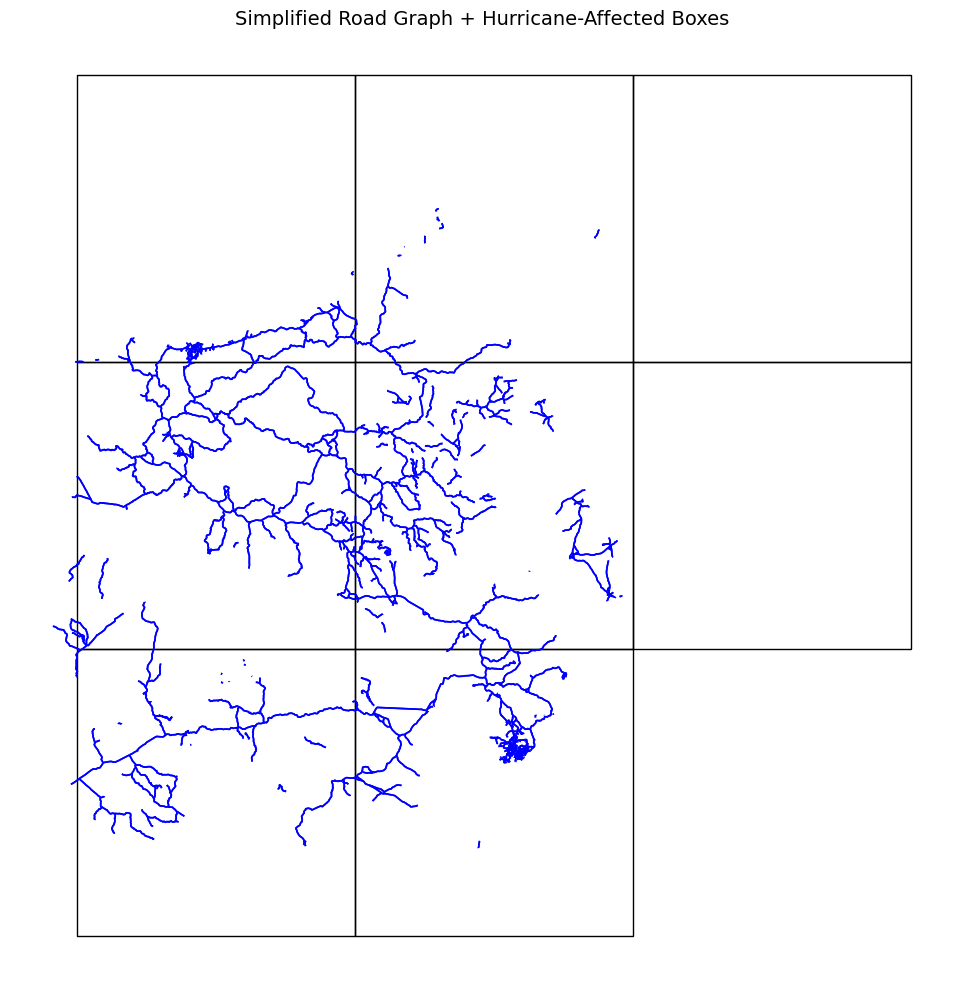

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Extract simplified edges with geometry
edge_feats = []
for u, v, k, data in G_simplified.edges(keys=True, data=True):
    geom = data.get("geometry")
    if geom:
        edge_feats.append({"geometry": geom})

edges_gdf = gpd.GeoDataFrame(edge_feats, crs=G_simplified.graph.get("crs", "EPSG:4326"))

# 2. Plot with hurricane grid overlay
fig, ax = plt.subplots(figsize=(10, 10))

# plot hurricane density boxes
top_right_cells.boundary.plot(ax=ax, edgecolor="black", linewidth=1.0)

# plot simplified graph
edges_gdf.plot(ax=ax, color="blue", linewidth=1.2)

ax.set_title("Simplified Road Graph + Hurricane-Affected Boxes", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## 5. Get demand nodes data

### 5.1 Use Open Street Map

In [24]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import random, requests
from shapely.geometry import Point, LineString

HOTSPOT = region_union

# 0a) Filter nodes to those inside the hotspot
nodes_inside = [
    n for n, data in G_simplified.nodes(data=True)
    if HOTSPOT.contains(Point(data["x"], data["y"]))
]
G_hot = G_simplified.subgraph(nodes_inside).copy()

# 0b) Drop edges that lie completely outside the hotspot
to_remove = []
for u, v, key, data in G_hot.edges(keys=True, data=True):
    geom = data.get("geometry")
    if geom is None:
        x1, y1 = G_hot.nodes[u]["x"], G_hot.nodes[u]["y"]
        x2, y2 = G_hot.nodes[v]["x"], G_hot.nodes[v]["y"]
        geom = LineString([(x1, y1), (x2, y2)])
    if not HOTSPOT.intersects(geom):
        to_remove.append((u, v, key))
G_hot.remove_edges_from(to_remove)

print(f"Hotspot-only graph: {G_hot.number_of_nodes()} nodes, {G_hot.number_of_edges()} edges")

# -----------------------------------------------------------------
# 1.  Pull demand/warehouse points & keep only those in hotspot
# -----------------------------------------------------------------
OVERPASS = "https://overpass-api.de/api/interpreter"

def pull_points(query):
    resp = requests.post(OVERPASS, data={"data": query}).json()
    elements = resp.get("elements", [])
    points = []
    for el in elements:
        if el["type"] == "node":
            lon = el.get("lon")
            lat = el.get("lat")
        elif "center" in el:
            lon = el["center"]["lon"]
            lat = el["center"]["lat"]
        else:
            continue
        points.append(Point(lon, lat))
    return points

# Demand: broad set of facilities
Q_DEM = """
[out:json][timeout:60];
area["ISO3166-1"="NI"][admin_level=2]->.searchArea;
(
  node(area.searchArea)["amenity"~"school|hospital|kindergarten|pharmacy|clinic|supermarket|restaurant|building"];
  way(area.searchArea)["amenity"~"school|hospital|kindergarten|pharmacy|clinic|supermarket|restaurant"];
  relation(area.searchArea)["amenity"~"school|hospital|kindergarten|pharmacy|clinic|supermarket|restaurant"];
);
out center;
"""

# Warehouses: as before
Q_WAR = """
[out:json][timeout:25];
area["ISO3166-1"="NI"][admin_level=2];
(
  node(area)["building"="warehouse"];
  node(area)["amenity"="storage"];
);
out center;
"""

dem_pts_all  = [pt for pt in pull_points(Q_DEM) if HOTSPOT.contains(pt)]
ware_pts_all = [pt for pt in pull_points(Q_WAR) if HOTSPOT.contains(pt)]

# Convert ALL available points to GeoDataFrames (no sampling)
dem_gdf = gpd.GeoDataFrame(geometry=dem_pts_all, crs="EPSG:4326")
ware_ex = gpd.GeoDataFrame(geometry=ware_pts_all, crs="EPSG:4326")

# fallback: random nodes from graph if not enough warehouses
NUM_WAR_EXIST, NUM_WAR_CAND = 2, 3  # only used for fallback/candidate sampling

def extra_nodes(k):
    extras = random.sample(list(G_hot.nodes), k)
    return gpd.GeoDataFrame(
        geometry=[Point(G_hot.nodes[n]["x"], G_hot.nodes[n]["y"]) for n in extras],
        crs="EPSG:4326"
    )

if len(ware_ex) < NUM_WAR_EXIST:
    ware_ex = pd.concat([
        ware_ex,
        extra_nodes(NUM_WAR_EXIST - len(ware_ex))
    ], ignore_index=True)

ware_cand = extra_nodes(NUM_WAR_CAND)

# assign IDs
ware_ex["ware_id"]   = [f"WEX{i}" for i in range(len(ware_ex))]
ware_cand["ware_id"] = [f"WCA{i}" for i in range(len(ware_cand))]
dem_gdf["dem_id"]    = [f"D{i}"    for i in range(len(dem_gdf))]


Hotspot-only graph: 1939 nodes, 4500 edges


In [25]:
dem_gdf

,geometry,dem_id
0,POINT (-83.38272 14.02315),D0
1,POINT (-83.37332 14.03493),D1
2,POINT (-83.38089 14.04151),D2
3,POINT (-83.37972 14.03154),D3
4,POINT (-83.37973 14.03140),D4
...,...,...
76,POINT (-83.38089 14.03194),D76
77,POINT (-83.41623 14.02469),D77
78,POINT (-83.40595 14.03606),D78
79,POINT (-83.97849 14.72236),D79


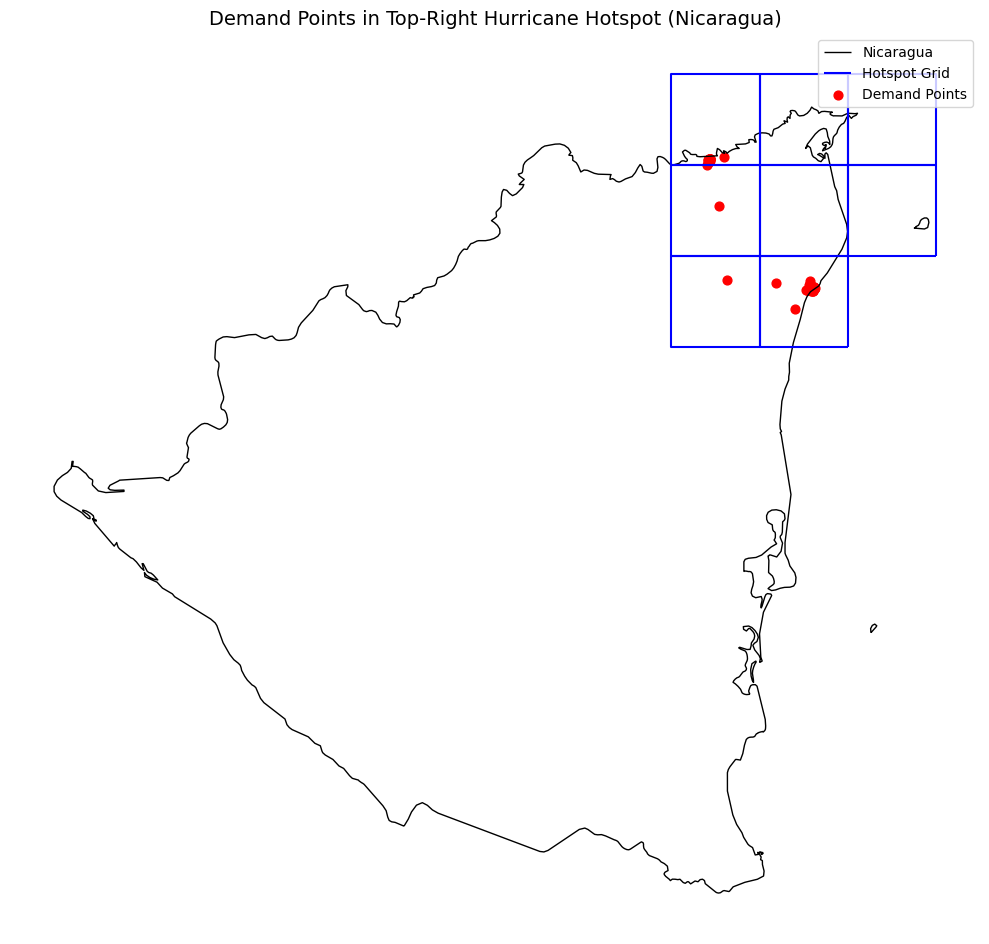

In [26]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Prepare GeoDataFrame for country boundary (if not already)
gdf_nic_outline = gpd.GeoDataFrame(geometry=[nic_poly], crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Nicaragua border
gdf_nic_outline.boundary.plot(ax=ax, edgecolor="black", linewidth=1, label="Nicaragua")

# Top-right hotspot region
top_right_cells.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.5, label="Hotspot Grid")

# Demand facilities
dem_gdf.plot(ax=ax, color="red", markersize=40, label="Demand Points")

# Titles and formatting
ax.set_title("Demand Points in Top-Right Hurricane Hotspot (Nicaragua)", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

### 5.2 Get population density map

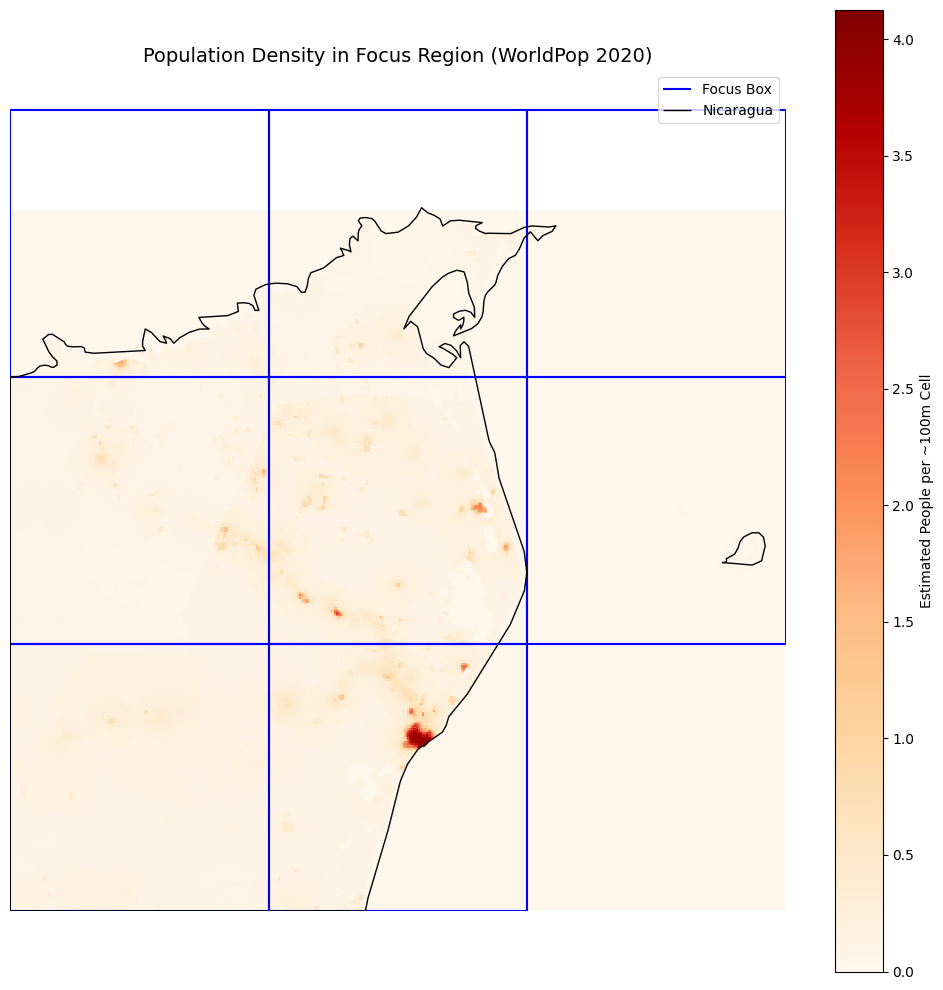

In [27]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from rasterio.mask import mask
import matplotlib.colors as colors

# Load raster
pop_path = "data/NIC_ppp_2020.tif"
src = rasterio.open(pop_path)

# Clip to hotspot region
out_image, out_transform = mask(src, [mapping(HOTSPOT)], crop=True)
pop_data = out_image[0]
pop_data[pop_data < 0] = 0  # Remove no-data values

# Get extent for imshow
xmin, ymin = out_transform * (0, pop_data.shape[0])
xmax, ymax = out_transform * (pop_data.shape[1], 0)
extent = [xmin, xmax, ymin, ymax]

# Reproject top_right_cells to match raster CRS
top_right_cells_proj = top_right_cells.to_crs(src.crs)
gdf_nic_clipped = gpd.clip(gdf_nic_outline, top_right_cells).to_crs(src.crs)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

img = ax.imshow(
    pop_data,
    cmap="OrRd",
#     norm=colors.LogNorm(vmin=1, vmax=pop_data.max()),
    extent=extent,
    interpolation="none",
    origin="upper"
)

# Overlay HOTSPOT grid boundary
top_right_cells_proj.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.5, label="Focus Box")

gdf_nic_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=1, label="Nicaragua")

# Final touches
plt.colorbar(img, ax=ax, label="Estimated People per ~100m Cell")
ax.set_title("Population Density in Focus Region (WorldPop 2020)", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [28]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# --- Threshold for minimum population per cell to be considered a demand point ---
POP_THRESHOLD = 1 # you can adjust this

# Identify nonzero population cells above threshold
rows, cols = np.where(pop_data > POP_THRESHOLD)
demands = pop_data[rows, cols]

# Convert row/col indices to coordinates using the raster's transform
xs, ys = rasterio.transform.xy(out_transform, rows, cols)
points = [Point(x, y) for x, y in zip(xs, ys)]

# Build GeoDataFrame of population-based demand nodes
population_demand_nodes = gpd.GeoDataFrame(
    {"demand": demands},
    geometry=points,
    crs=src.crs
)

# Reproject to EPSG:4326 if needed
population_demand_nodes = population_demand_nodes.to_crs("EPSG:4326")

# Add unique demand IDs
population_demand_nodes["dem_id"] = [f"PD{i}" for i in range(len(population_demand_nodes))]

print(f"✓ Created {len(population_demand_nodes)} population-based demand nodes.")

✓ Created 6735 population-based demand nodes.


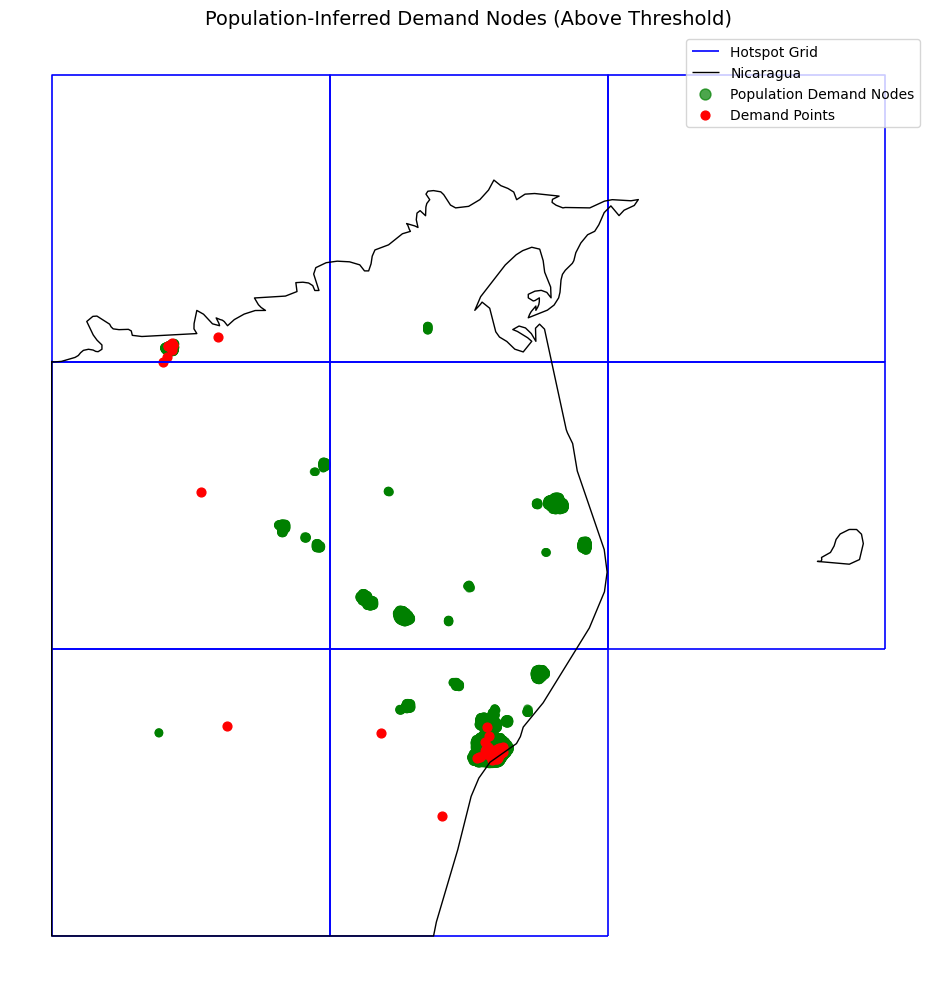

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

# Overlay grid focus area
top_right_cells.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.2, label="Hotspot Grid")

gdf_nic_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=1, label="Nicaragua")

# Plot population demand nodes, scaled by their demand
population_demand_nodes.plot(
    ax=ax,
    markersize=population_demand_nodes["demand"] / population_demand_nodes["demand"].max() * 100,
    color="green",
    alpha=0.7,
    label="Population Demand Nodes"
)

dem_gdf.plot(ax=ax, color="red", markersize=40, label="Demand Points")

ax.set_title("Population-Inferred Demand Nodes (Above Threshold)", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [30]:
population_demand_nodes

,demand,geometry,dem_id
0,1.074539,POINT (-83.51000 14.77667),PD0
1,1.033135,POINT (-83.50917 14.77667),PD1
2,1.014338,POINT (-83.50833 14.77667),PD2
3,1.083593,POINT (-83.51000 14.77583),PD3
4,1.057155,POINT (-83.50917 14.77583),PD4
...,...,...,...
6730,1.147315,POINT (-83.40250 14.01500),PD6730
6731,1.510507,POINT (-83.40167 14.01500),PD6731
6732,1.622180,POINT (-83.40083 14.01500),PD6732
6733,1.637533,POINT (-83.40000 14.01500),PD6733


In [31]:
dem_gdf

,geometry,dem_id
0,POINT (-83.38272 14.02315),D0
1,POINT (-83.37332 14.03493),D1
2,POINT (-83.38089 14.04151),D2
3,POINT (-83.37972 14.03154),D3
4,POINT (-83.37973 14.03140),D4
...,...,...
76,POINT (-83.38089 14.03194),D76
77,POINT (-83.41623 14.02469),D77
78,POINT (-83.40595 14.03606),D78
79,POINT (-83.97849 14.72236),D79


### 5.3 Merge demand nodes

In [32]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- PARAMETERS ---
CLUSTER_DISTANCE = 500   # meters for clustering
MIN_DEMAND        = 10.0 # minimum demand for clusters without any population nodes

# --- ASSUMPTION ---
# You have two GeoDataFrames:
# • population_demand_nodes with columns ['dem_id', 'demand', 'geometry']
# • dem_gdf                with columns ['dem_id',         'geometry']

# STEP 1: Tag sources and set demand=0 for relevant-location points
population = population_demand_nodes.copy()
population["source"] = "population"

relevant = dem_gdf.copy()
relevant["source"] = "relevant"
relevant["demand"] = 0.0  # will be overridden by MIN_DEMAND if no population

# STEP 2: Combine both datasets
population = population[["dem_id", "demand", "geometry", "source"]]
relevant  = relevant[["dem_id", "demand", "geometry", "source"]]
combined  = pd.concat([population, relevant], ignore_index=True)

# STEP 3: Project to metric CRS for clustering
combined = gpd.GeoDataFrame(combined, geometry="geometry", crs="EPSG:4326") \
                   .to_crs(epsg=3857)

# STEP 4: Run DBSCAN on all points
coords = np.vstack([combined.geometry.x, combined.geometry.y]).T
combined["cluster"] = DBSCAN(eps=CLUSTER_DISTANCE, min_samples=1).fit_predict(coords)

# STEP 5: Aggregate by cluster
def make_centroid(geoms):
    xs = [p.x for p in geoms]
    ys = [p.y for p in geoms]
    return Point(np.mean(xs), np.mean(ys))

clustered = (
    combined.groupby("cluster")
    .apply(lambda g: pd.Series({
        # sum only the population demands
        "demand": g.loc[g.source == "population", "demand"].sum(),
        "geometry": make_centroid(g.geometry),
        "source": "+".join(sorted(set(g.source)))
    }))
    .reset_index(drop=True)
)

# STEP 6: Enforce minimum demand for clusters with only 'relevant'
mask_relevant_only = clustered["source"] == "relevant"
clustered.loc[mask_relevant_only, "demand"] = clustered.loc[mask_relevant_only, "demand"].apply(
    lambda x: max(x, MIN_DEMAND)
)

# STEP 7: Wrap into GeoDataFrame & reproject back to lat/lon
clustered = gpd.GeoDataFrame(clustered, geometry="geometry", crs=3857) \
                   .to_crs(epsg=4326)

# STEP 8: Assign new dem_id
clustered["dem_id"] = ["CL" + str(i) for i in range(len(clustered))]

# Final table
final = clustered[["dem_id", "demand", "geometry", "source"]]

print(f"✓ Final table includes {len(final)} clustered demand nodes.")
print(final.head())

✓ Final table includes 34 clustered demand nodes.
  dem_id      demand                    geometry               source
0    CL0   31.118455  POINT (-83.50917 14.77284)           population
1    CL1  389.359817  POINT (-83.97205 14.73782)  population+relevant
2    CL2  105.921179  POINT (-83.69492 14.53466)           population
3    CL3    5.212513  POINT (-83.71250 14.52250)           population
4    CL4    9.321969  POINT (-83.57972 14.48815)           population


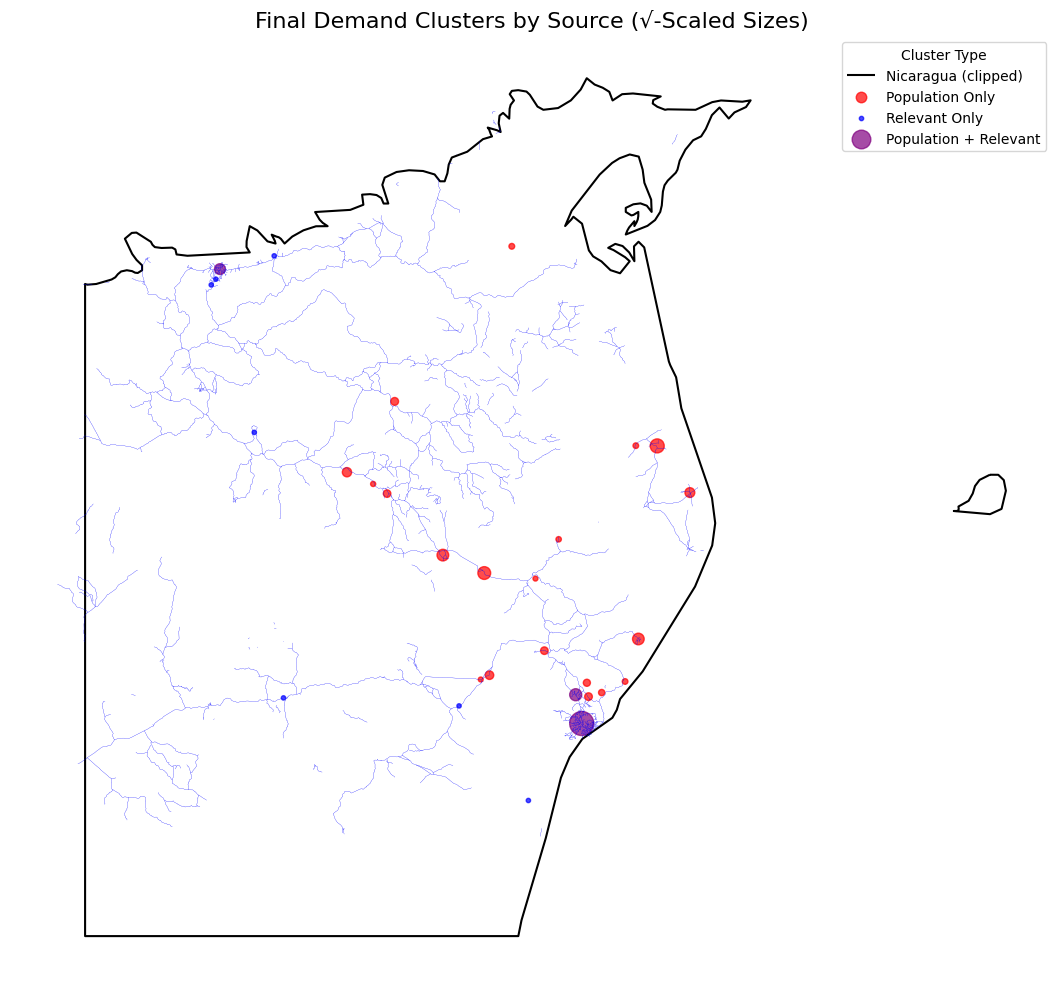

In [33]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# final: your clustered GeoDataFrame in EPSG:4326
# gdf_nic_clipped: clipped Nicaragua boundary, EPSG:4326

final = final.query("demand >= 10")

# 1. Compute square‐root transformed demands and global max on that scale
sqrt_demands = np.sqrt(final['demand'])
global_sqrt_max = sqrt_demands.max()

# Choose maximum marker size
MAX_MARKER_SIZE = 300

# 2. Function to compute sqrt‐scaled marker sizes
def sqrt_marker_sizes(dem_series):
    return np.sqrt(dem_series) / global_sqrt_max * MAX_MARKER_SIZE

# 3. Split by source
cat_pop_only = final[final['source']=='population']
cat_rel_only = final[final['source']=='relevant']
cat_both     = final[final['source']=='population+relevant']

# 4. Plot
fig, ax = plt.subplots(figsize=(12,10))

# Boundary
gdf_nic_clipped.boundary.plot(
    ax=ax, edgecolor='black', linewidth=1.5, label='Nicaragua (clipped)'
)

# Population-only (red)
cat_pop_only.plot(
    ax=ax,
    color='red',
    markersize=sqrt_marker_sizes(cat_pop_only['demand']),
    label='Population Only',
    alpha=0.7
)

# Relevant-only (blue)
cat_rel_only.plot(
    ax=ax,
    color='blue',
    markersize=sqrt_marker_sizes(cat_rel_only['demand']),
    label='Relevant Only',
    alpha=0.7
)

# Mixed (purple)
cat_both.plot(
    ax=ax,
    color='purple',
    markersize=sqrt_marker_sizes(cat_both['demand']),
    label='Population + Relevant',
    alpha=0.7
)

edges_gdf.plot(ax=ax, color="blue", linewidth=0.1)

# Final touches
ax.set_title("Final Demand Clusters by Source (√-Scaled Sizes)", fontsize=16)
ax.legend(title="Cluster Type")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [34]:
# final["demand"] = final["demand"].clip(0, 3000)

## Structure of optimization model

In [35]:
import random
import warnings
from collections import defaultdict
from pathlib import Path

import geopandas as gpd
import networkx as nx
import numpy as np
import pyproj
import shapely.ops
from geopy.distance import geodesic
from shapely.geometry import LineString, Point
from shapely.ops import unary_union
from tqdm import tqdm

# ---------------------------------------------------------------------------
# 0. User‑adjustable hyper‑parameters
# ---------------------------------------------------------------------------
N_WAREHOUSE_CANDIDATES = 20      # |I_N|
HURR_BUFFER_KM         = 2.0    # radius around track considered disrupted
EDGE_SNAP_TOLERANCE_M  = 25.0    # tolerance when snapping demand/warehouse pts to graph

In [36]:
# -*- coding: utf-8 -*-
"""
Build Sets & Parameters for UNICEF Hurricane Preparedness Model
----------------------------------------------------------------
• Keeps all previous logic (inventory survival ρᵢˢ, scenario filtering, etc.).
• NEW: adds warehouse build-cost hᵢ that is higher when the warehouse is
       geographically closer to demand nodes.
"""
import random, warnings, math
from collections import defaultdict
from copy import deepcopy
from pathlib import Path

import geopandas as gpd
import networkx as nx
import numpy as np
import pyproj, shapely.ops
from geopy.distance import geodesic
from shapely.geometry import LineString, Point
from tqdm import tqdm

# ---------------------------------------------------------------------------
# 0. Hyper-parameters
# ---------------------------------------------------------------------------
N_WAREHOUSE_CANDIDATES = 100
HURR_BUFFER_KM         = 2.0
EDGE_SNAP_TOLERANCE_M  = 5_000.0

# Survival-decay for inventory (unchanged) -----------------------------------
DAMAGE_RADIUS_KM = 10.0
MIN_SURVIVAL     = 0.2

# ---------------------------------------------------------------------------
# 1. Geodesic helpers
# ---------------------------------------------------------------------------
from functools import lru_cache
@lru_cache(maxsize=None)
def _get_proj(lon, lat):
    proj = f"+proj=aeqd +lat_0={lat} +lon_0={lon} +units=m +datum=WGS84"
    return (pyproj.Transformer.from_crs("EPSG:4326", proj, always_xy=True),
            pyproj.Transformer.from_crs(proj, "EPSG:4326", always_xy=True))

def geodesic_buffer(line: LineString, r_km: float):
    lon0, lat0 = line.coords[len(line.coords)//2]
    fwd, inv = _get_proj(lon0, lat0)
    buf = LineString([fwd.transform(*p) for p in line.coords]).buffer(r_km*1000)
    return shapely.ops.transform(inv.transform, buf) if not buf.is_empty else LineString()

def point_track_distance_km(lon, lat, track):
    fwd, _ = _get_proj(lon, lat)
    proj_pt   = Point(0, 0)
    proj_line = LineString([fwd.transform(*p) for p in track])
    return proj_pt.distance(proj_line) / 1000.0

# ---------------------------------------------------------------------------
# 2. Warehouse sampler (unchanged)
# ---------------------------------------------------------------------------
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
def sample_candidate_warehouses_distributed(G, k, random_state=0):
    nodes  = list(G.nodes)
    coords = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in nodes])
    cent   = KMeans(k, random_state=random_state).fit(coords).cluster_centers_
    idx    = cKDTree(coords).query(cent, k=1)[1]
    samp   = [nodes[i] for i in idx]
    return gpd.GeoDataFrame({
        "ware_id"  : [f"W{i}" for i in range(k)],
        "graph_nid": samp,
        "geometry" : [Point(G.nodes[n]['x'], G.nodes[n]['y']) for n in samp]
    }, crs="EPSG:4326")

# ---------------------------------------------------------------------------
# 3. Snap helper (unchanged)
# ---------------------------------------------------------------------------
def snap_points_to_graph(gdf_pts, G, tol_m):
    nodes=list(G.nodes)
    xs=np.array([G.nodes[n]["x"] for n in nodes]); ys=np.array([G.nodes[n]["y"] for n in nodes])
    proj=pyproj.Transformer.from_crs("EPSG:4326",3857,always_xy=True).transform
    xs_m,ys_m=proj(xs,ys); tree=cKDTree(np.column_stack([xs_m,ys_m]))
    keep,snapped=[],[]
    for idx,pt in enumerate(gdf_pts.geometry):
        x_m,y_m=proj(pt.x,pt.y); dist,idx_n=tree.query([x_m,y_m])
        if dist>tol_m:
            warnings.warn(f"ValueError: {pt.wkt} is {dist:.1f} m from nearest road node > tol.")
            continue
        keep.append(idx); snapped.append(nodes[idx_n])
    out=gdf_pts.iloc[keep].copy(); out["graph_nid"]=snapped
    out.reset_index(drop=True,inplace=True); return out

# ---------------------------------------------------------------------------
# 4. Shortest-path routine (unchanged)
# ---------------------------------------------------------------------------
def compute_shortest_paths(G,sources,targets):
    for u,v,k,d in G.edges(keys=True,data=True):
        d["weight"]=float(geodesic((G.nodes[u]['y'],G.nodes[u]['x']),
                                   (G.nodes[v]['y'],G.nodes[v]['x'])).km)
    res={}
    for i_id,i_nid in tqdm(sources.items(),desc="Shortest paths",leave=False):
        dist,path=nx.multi_source_dijkstra(G,[i_nid],weight="weight")
        for j_id,j_nid in targets.items():
            if j_nid not in dist: continue
            node_path=path[j_nid]
            edges=[(uu,vv,0) for uu,vv in zip(node_path[:-1],node_path[1:])]
            res[(i_id,j_id)]=(dist[j_nid],edges)
    return res

# ---------------------------------------------------------------------------
# 5. Disrupted edges (unchanged)
# ---------------------------------------------------------------------------
def disrupted_edges_for_scenario(G,track,buff_km):
    buff=geodesic_buffer(LineString(track),buff_km)
    dis=set()
    for u,v,k,d in G.edges(keys=True,data=True):
        geom=d.get("geometry") or LineString([(G.nodes[u]['x'],G.nodes[u]['y']),
                                              (G.nodes[v]['x'],G.nodes[v]['y'])])
        if buff.intersects(geom): dis.add((u,v,k))
    return dis

# ---------------------------------------------------------------------------
# 6. Master routine
# ---------------------------------------------------------------------------
def build_sets_and_params(G_hot, final_gdf, scenario_list):

    # Warehouses & demand nodes ---------------------------------------------
    ware_gdf = sample_candidate_warehouses_distributed(G_hot, N_WAREHOUSE_CANDIDATES)
    ware_gdf = snap_points_to_graph(ware_gdf, G_hot, EDGE_SNAP_TOLERANCE_M)
    dem_gdf  = snap_points_to_graph(final_gdf.copy(), G_hot, EDGE_SNAP_TOLERANCE_M)
    if "dem_id" not in dem_gdf: dem_gdf["dem_id"]=[f"D{i}" for i in range(len(dem_gdf))]
    if "demand" not in dem_gdf: dem_gdf["demand"]=1.0

    # Baseline paths ---------------------------------------------------------
    sources = dict(zip(ware_gdf.ware_id, ware_gdf.graph_nid))
    targets = dict(zip(dem_gdf.dem_id , dem_gdf.graph_nid))
    base_paths = compute_shortest_paths(G_hot, sources, targets)
    c_ij_base  = {k:v[0] for k,v in base_paths.items()}
    path_edges = {k:v[1] for k,v in base_paths.items()}

    # --- ADD: build-cost h_i (closer to demand → more expensive) ------------
    nearest = {}
    for i in ware_gdf.ware_id:
        dists = [
            c_ij_base[(i, j)]
            for j in dem_gdf.dem_id
            if (i, j) in c_ij_base                # skip disconnected pairs
        ]
        if dists:                                # at least one reachable demand
            nearest[i] = min(dists)
        else:
            nearest[i] = float('inf')            # treat as far away (baseline cost)

    max_d = max(v for v in nearest.values() if math.isfinite(v)) + 1e-6
    h_i   = {i: (1000.0 if not math.isfinite(nearest[i])
                 else 1000.0 + 500.0 * (1 - nearest[i] / max_d))
             for i in ware_gdf.ware_id}
# ------------------------------------------------------------------------

    # -----------------------------------------------------------------------

    # Scenario loop ----------------------------------------------------------
    disrupted_s, a_ij_s, c_ij_s = {}, defaultdict(dict), defaultdict(dict)
    rho_i_s, kept_scenarios   = {}, []

    for sc in tqdm(scenario_list,desc="Scenarios",leave=False):
        s_id = sc["scenario_id"]
        dis  = disrupted_edges_for_scenario(G_hot, sc["track"], HURR_BUFFER_KM)
        if len(dis)==0:
            warnings.warn(f"Scenario {s_id} discarded (no disrupted edges).")
            continue
        kept_scenarios.append(sc); disrupted_s[s_id]=dis

        G_pruned = deepcopy(G_hot); G_pruned.remove_edges_from(dis)
        for (i,j),(dist0,_) in base_paths.items():
            try:
                alt = nx.shortest_path_length(G_pruned, sources[i], targets[j], weight="weight")
                a_ij_s[s_id][(i,j)], c_ij_s[s_id][(i,j)] = 1, alt
            except (nx.NetworkXNoPath, KeyError):
                a_ij_s[s_id][(i,j)], c_ij_s[s_id][(i,j)] = 0, math.inf

        # inventory survival -------------------------------------------------
        rho_i_s[s_id] = {}
        for _, row in ware_gdf.iterrows():
            dk = point_track_distance_km(row.geometry.x, row.geometry.y, sc["track"])
            rho = 1.0 if dk>=DAMAGE_RADIUS_KM else MIN_SURVIVAL + (1-MIN_SURVIVAL)*(dk/DAMAGE_RADIUS_KM)
            rho_i_s[s_id][row.ware_id]=rho

    # Probability renormalisation -------------------------------------------
    if not kept_scenarios: raise ValueError("All scenarios discarded.")
    raw = {sc["scenario_id"]: sc.get("probability", 1/len(scenario_list)) for sc in kept_scenarios}
    tot = sum(raw.values()); prob_s = {k:v/tot for k,v in raw.items()}

    # Assemble & return ------------------------------------------------------
    sets = {"I_N": ware_gdf.ware_id.tolist(),
            "J"  : dem_gdf.dem_id.tolist(),
            "S"  : [sc["scenario_id"] for sc in kept_scenarios]}

    params = {"prob_s"            : prob_s,
              "demand_j"          : dict(zip(dem_gdf.dem_id, dem_gdf.demand)),
              "h_i"               : h_i,            ### <-- new entry
              "c_ij_base"         : c_ij_base,
              "c_ij_s"            : c_ij_s,
              "path_edges_ij"     : path_edges,
              "disrupted_edges_s" : disrupted_s,
              "a_ij_s"            : a_ij_s,
              "rho_i_s"           : rho_i_s}

    return sets, params, ware_gdf, dem_gdf, kept_scenarios

In [37]:
# build data
sets, params, ware_gdf, dem_gdf, kept_scenarios = build_sets_and_params(
    G_hot, final, scenario_list
)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [38]:
# Save data in Json (better Julia readibility)

import json, math
from pathlib import Path

BIG = 1e15                       # sentinel for Infinity

Path("inputs_opti").mkdir(exist_ok=True)

# ---------- helper to make any object JSON-serialisable --------------------
def jsonable(obj):
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            if isinstance(k, tuple):
                k = "§".join(map(str, k))
            out[k] = jsonable(v)
        return out
    elif isinstance(obj, (list, tuple, set)):
        return [jsonable(x) for x in obj]
    elif isinstance(obj, float) and (math.isinf(obj) or math.isnan(obj)):
        return BIG                       # replace ±Inf, NaN
    else:
        return obj
# ---------------------------------------------------------------------------

(Path("inputs_opti") / "sets.json"  ).write_text(json.dumps(jsonable(sets),   indent=2))
(Path("inputs_opti") / "params.json").write_text(json.dumps(jsonable(params), indent=2))

# keep GeoJSON layers
ware_gdf.to_file("inputs_opti/warehouses.geojson", driver="GeoJSON")
dem_gdf.to_file("inputs_opti/demand_nodes.geojson", driver="GeoJSON")

print("✓ Saved sets.json, params.json with BIG=1e15 for infinities")

✓ Saved sets.json, params.json with BIG=1e15 for infinities


## Plot impacted roads

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import transform
from functools import lru_cache
import pyproj
import warnings                                        ### <<< CHANGED >>>

def plot_hurricane_disruption_zoomed(
    G_hot,
    scenario_id,                                       ### <<< CHANGED >>>
    buffer_km,
    gdf_nic_clipped,
    kept_scenarios,                                    ### <<< CHANGED >>>
):
    """
    Plot roads, disruptions, and hurricane track, clipped & zoomed
    to the Nicaragua polygon, **but only for scenarios that survived
    the filtering step (kept_scenarios)**.

    Parameters
    ----------
    G_hot : MultiDiGraph
    scenario_id : str
        ID (e.g. "AL041890") of the hurricane to plot.
    buffer_km : float
    gdf_nic_clipped : GeoDataFrame
        Boundary polygon for zooming / clipping.
    kept_scenarios : list[dict]
        The list returned by build_sets_and_params that excludes
        scenarios with zero disrupted edges.
    """
    # ------------------------------------------------------------------ check
    kept_map = {sc["scenario_id"]: sc for sc in kept_scenarios}     
    if scenario_id not in kept_map:
        warnings.warn(f"Scenario {scenario_id} was discarded — nothing to plot.")
        return
    scenario = kept_map[scenario_id]

    # ------------------------------------------------------------------ figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # 0. Nicaragua boundary
    gdf_nic_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

    # 1. All roads (thin blue)
    roads = [
        data.get("geometry")
        or LineString([(G_hot.nodes[u]["x"], G_hot.nodes[u]["y"]),
                       (G_hot.nodes[v]["x"], G_hot.nodes[v]["y"])])
        for u, v, k, data in G_hot.edges(keys=True, data=True)
    ]
    gpd.GeoSeries(roads, crs="EPSG:4326").plot(ax=ax, color="blue", linewidth=0.1)

    # 2. Buffer around track --------------------------------------------------
    @lru_cache(maxsize=None)
    def _proj(lon, lat):
        s = f"+proj=aeqd +lat_0={lat} +lon_0={lon} +units=m +datum=WGS84"
        return (
            pyproj.Transformer.from_crs("EPSG:4326", s, always_xy=True),
            pyproj.Transformer.from_crs(s, "EPSG:4326", always_xy=True),
        )

    def geodesic_buffer(line, radius_km):
        lon0, lat0 = list(line.coords)[len(line.coords) // 2]
        fwd, inv = _proj(lon0, lat0)
        buff = transform(fwd.transform, line).buffer(radius_km * 1_000)
        return transform(inv.transform, buff) if not buff.is_empty else buff

    track_line = LineString(scenario["track"])
    buff = geodesic_buffer(track_line, buffer_km)

    # 3. Disrupted roads (red)
    disrupted = []
    for u, v, k, data in G_hot.edges(keys=True, data=True):
        geom = data.get("geometry") or LineString([
            (G_hot.nodes[u]["x"], G_hot.nodes[u]["y"]),
            (G_hot.nodes[v]["x"], G_hot.nodes[v]["y"])
        ])
        if buff.intersects(geom):
            disrupted.append(geom)

    if disrupted:
        gpd.GeoSeries(disrupted, crs="EPSG:4326").plot(
            ax=ax, color="red", linewidth=1.5, label="Disrupted"
        )

    # 4. Hurricane track (dashed black)
    gpd.GeoSeries([track_line], crs="EPSG:4326").plot(
        ax=ax, color="black", linewidth=2, linestyle="--"
    )

    # 5. Zoom to clipped Nicaragua bounds
    minx, miny, maxx, maxy = gdf_nic_clipped.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # 6. Plot demand & warehouse points (optional, uses globals)
    try:
        ware_gdf.plot(ax=ax, color="orange", markersize=10, label="Warehouses")
        dem_gdf.plot(ax=ax, color="green",  markersize=6, label="Demand Nodes")
    except NameError:
        pass  # if vars aren't in scope

    ax.set_title(f"Hurricane {scenario_id} — Disruptions in Focus Area")
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()


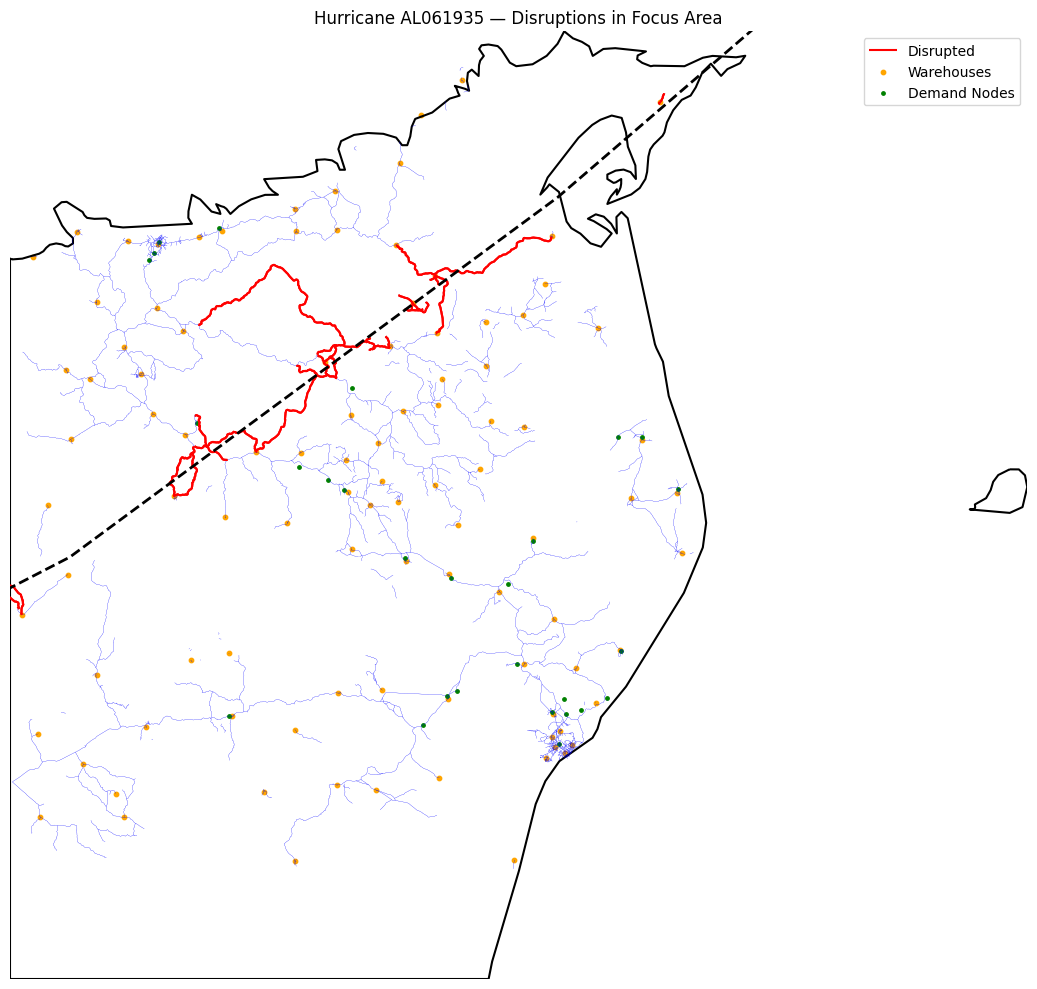

In [40]:
scenario_id = list(params["prob_s"].keys())[3]


# --- Example usage -----------------------------------------------------------
plot_hurricane_disruption_zoomed(
    G_hot,
    scenario_id=scenario_id,
    buffer_km=HURR_BUFFER_KM,
    gdf_nic_clipped=gdf_nic_clipped,
    kept_scenarios=kept_scenarios,   # list returned by build_sets_and_params
)

## Results Analysis

In [41]:
import json
import warnings

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from shapely.geometry import LineString
from shapely.ops import transform
from functools import lru_cache
import pyproj

# ────────────────────────────────────────────────────────────────
# Constants & helper colormap
# ────────────────────────────────────────────────────────────────
GREEN    = "#2ECC40"
DARK_RED = "#B20000"
cmap_red = cm.get_cmap("Reds")

def node_color(unmet: float) -> str:
    """
    Unmet == 0   → bright GREEN
    0 < unmet    → shade of RED (clamped to [0.1,1.0] on Reds)
    unmet >=200 → DARK_RED
    """
    if unmet <= 0:
        return GREEN
    ratio = unmet / 200.0
    if ratio > 1.0:
        return DARK_RED
    ratio = max(ratio, 0.1)
    return mcolors.to_hex(cmap_red(ratio))


# ────────────────────────────────────────────────────────────────
# 1. Full‐solution map
# ────────────────────────────────────────────────────────────────
def plot_solution_map(
    G_hot,
    kept_scenarios,
    ware_gdf_opt,
    ware_gdf_base,
    dem_gdf,
    gdf_nic_clipped,
    output_dir="output",
    solution="optimal"        # "optimal" or "baseline"
):
    """
    Nicaragua‐wide solution map:
      • Roads & all hurricane tracks
      • Demand nodes colored by unmet‐demand intensity,
        with a thin red border only on nodes with unmet>0
      • Candidate warehouses (gray squares) & built (blue squares)
    """
    # Load which were built
    built = json.load(open(f"{output_dir}/built_warehouses.json"))

    # Select columns and ware_gdf
    if solution == "optimal":
        sat_col, unmet_col = "satisfied_opt", "unmet_optimal"
        built_ids          = built["built_optimal"]
        ware_gdf           = ware_gdf_opt
        title_tag          = "Optimal Solution"
    else:
        sat_col, unmet_col = "satisfied_base", "unmet_baseline"
        built_ids          = built["built_baseline"]
        ware_gdf           = ware_gdf_base
        title_tag          = "Baseline Solution"

    # Load demand satisfaction
    dem_df   = pd.read_csv(f"{output_dir}/demand_satisfaction.csv")
    dem_plot = dem_gdf.merge(
        dem_df[["dem_id", sat_col, unmet_col]],
        on="dem_id", how="left"
    ).fillna({sat_col:1.0, unmet_col:0.0})

    # Split met vs unmet
    met_df   = dem_plot[dem_plot[unmet_col] == 0]
    unmet_df = dem_plot[dem_plot[unmet_col] >  0]

    # Build roads
    roads = []
    for u, v, k, data in G_hot.edges(keys=True, data=True):
        geom = data.get("geometry") or LineString([
            (G_hot.nodes[u]["x"], G_hot.nodes[u]["y"]),
            (G_hot.nodes[v]["x"], G_hot.nodes[v]["y"])
        ])
        roads.append(geom)
    roads_clip = gpd.clip(gpd.GeoSeries(roads, crs="EPSG:4326"), gdf_nic_clipped)

    # Plot setup
    fig, ax = plt.subplots(figsize=(12,10))
    gdf_nic_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=1.2)
    minx, miny, maxx, maxy = gdf_nic_clipped.total_bounds
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)

    # Roads & tracks
    roads_clip.plot(ax=ax, color="lightblue", linewidth=0.3, label="Roads")
    for sc in kept_scenarios:
        xs, ys = zip(*sc["track"])
        ax.plot(xs, ys, color="cyan", linewidth=0.3, alpha=0.5)

    # Demand nodes: first those fully met (green, no border)
    met_df.plot(ax=ax,
                markersize=60,
                color=GREEN,
                edgecolor="none",
                alpha=0.9,
                label="Demand (met)")

    # Then those with unmet >0 (red‐shaded face + thin dashed red border)
    faces = [node_color(u) for u in unmet_df[unmet_col]]
    unmet_df.plot(ax=ax,
                  markersize=60,
                  facecolor=faces,
                  edgecolor="red",
                  linewidth=0.5,
                  linestyle="--",
                  alpha=0.9,
                  label="Demand (unmet)")

    # Warehouses
    ware_gdf.plot(ax=ax,
                  marker="s", color="lightgray",
                  edgecolor="black", linewidth=0.3,
                  markersize=40, label="Candidate wh")
    built_gdf = ware_gdf[ware_gdf["ware_id"].isin(built_ids)]
    built_gdf.plot(ax=ax,
                   marker="s", color="blue",
                   edgecolor="white", linewidth=0.6,
                   markersize=120, label="Built wh")

    ax.set_axis_off()
    ax.set_title(f"UNICEF Hurricane Preparedness — {title_tag}", fontsize=16)
    ax.legend(loc="upper left", framealpha=1)
    plt.tight_layout()
    plt.show()


# ────────────────────────────────────────────────────────────────
# 2. Scenario‐zoom map
# ────────────────────────────────────────────────────────────────
def plot_hurricane_disruption_zoomed(
    G_hot,
    scenario_id,
    gdf_nic_clipped,
    kept_scenarios,
    ware_gdf_opt,
    ware_gdf_base,
    dem_gdf,
    output_dir="output",
    buffer_km=2.0,
    solution="optimal"        # "optimal" or "baseline"
):
    """
    Zoomed scenario map:
      • Roads intact (blue) & disrupted (red)
      • Track (dashed black)
      • Warehouses & demand nodes (green vs red‐shaded with thin border)
    """
    # Load data
    built      = json.load(open(f"{output_dir}/built_warehouses.json"))
    unmet_tbl  = pd.read_csv(f"{output_dir}/demand_unmet.csv")

    # Scenario check
    sc_map = {sc["scenario_id"]: sc for sc in kept_scenarios}
    if scenario_id not in sc_map:
        warnings.warn(f"Scenario {scenario_id} discarded."); return
    scenario = sc_map[scenario_id]

    # Pick columns & ware_gdf
    if solution == "optimal":
        qty_col, built_ids = "unmet_qty_opt",  built["built_optimal"]
        ware_gdf, title_tag = ware_gdf_opt,      "Optimal"
    else:
        qty_col, built_ids = "unmet_qty_base", built["built_baseline"]
        ware_gdf, title_tag = ware_gdf_base,    "Baseline"

    # Merge unmet for this scenario
    df_s = unmet_tbl[unmet_tbl["scenario_id"] == scenario_id]
    dem_plot = dem_gdf.merge(df_s[["dem_id", qty_col]],
                             on="dem_id", how="left")\
                      .fillna({qty_col:0.0})

    # Split met vs unmet
    met_df   = dem_plot[dem_plot[qty_col] == 0]
    unmet_df = dem_plot[dem_plot[qty_col] >  0]

    # Build roads & compute disruptions
    @lru_cache(maxsize=None)
    def _proj(lon, lat):
        p = f"+proj=aeqd +lat_0={lat} +lon_0={lon} +units=m +datum=WGS84"
        return (pyproj.Transformer.from_crs("EPSG:4326", p, always_xy=True),
                pyproj.Transformer.from_crs(p, "EPSG:4326", always_xy=True))
    def geo_buf(line, km):
        lon0,lat0 = line.coords[len(line.coords)//2]
        fwd,inv   = _proj(lon0, lat0)
        buf_m     = transform(fwd.transform, line).buffer(km*1000)
        return transform(inv.transform, buf_m)

    roads = []
    for u,v,k,data in G_hot.edges(keys=True, data=True):
        geom = data.get("geometry") or LineString([
            (G_hot.nodes[u]["x"], G_hot.nodes[u]["y"]),
            (G_hot.nodes[v]["x"], G_hot.nodes[v]["y"])
        ])
        roads.append(geom)
    track = LineString(scenario["track"])
    buff  = geo_buf(track, buffer_km)
    disrupted = [g for g in roads if buff.intersects(g)]

    # Plot
    fig, ax = plt.subplots(figsize=(12,10))
    gdf_nic_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)
    gpd.GeoSeries(roads, crs="EPSG:4326").plot(ax=ax,
                                              color="blue", linewidth=0.1)
    if disrupted:
        gpd.GeoSeries(disrupted, crs="EPSG:4326").plot(
            ax=ax, color="red", linewidth=1.5, label="Disrupted")
    gpd.GeoSeries([track], crs="EPSG:4326").plot(ax=ax,
                                                 color="black",
                                                 linestyle="--",
                                                 linewidth=2,
                                                 label="Track")

    # Warehouses
    ware_gdf.plot(ax=ax,
                  marker="s", color="lightgray",
                  edgecolor="black", linewidth=0.3,
                  markersize=40, label="Candidate")
    built_gdf = ware_gdf[ware_gdf["ware_id"].isin(built_ids)]
    built_gdf.plot(ax=ax,
                   marker="s", color="blue",
                   edgecolor="white", linewidth=0.6,
                   markersize=120, label="Built")

    # Demand nodes
    met_df.plot(ax=ax,
                markersize=50,
                color=GREEN,
                edgecolor="none",
                alpha=0.9,
                label="Demand (met)")
    faces = [node_color(u) for u in unmet_df[qty_col]]
    unmet_df.plot(ax=ax,
                  markersize=50,
                  facecolor=faces,
                  edgecolor="red",
                  linewidth=0.5,
                  linestyle="--",
                  alpha=0.9,
                  label="Demand (unmet)")

    minx,miny,maxx,maxy = gdf_nic_clipped.total_bounds
    ax.set_xlim(minx,maxx); ax.set_ylim(miny,maxy)
    ax.set_title(f"Hurricane {scenario_id} — {title_tag}", fontsize=16)
    ax.set_axis_off()
    ax.legend(loc="upper left", framealpha=1)
    plt.tight_layout()
    plt.show()

<ipython-input-41-a3d392c9deaa>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_red = cm.get_cmap("Reds")


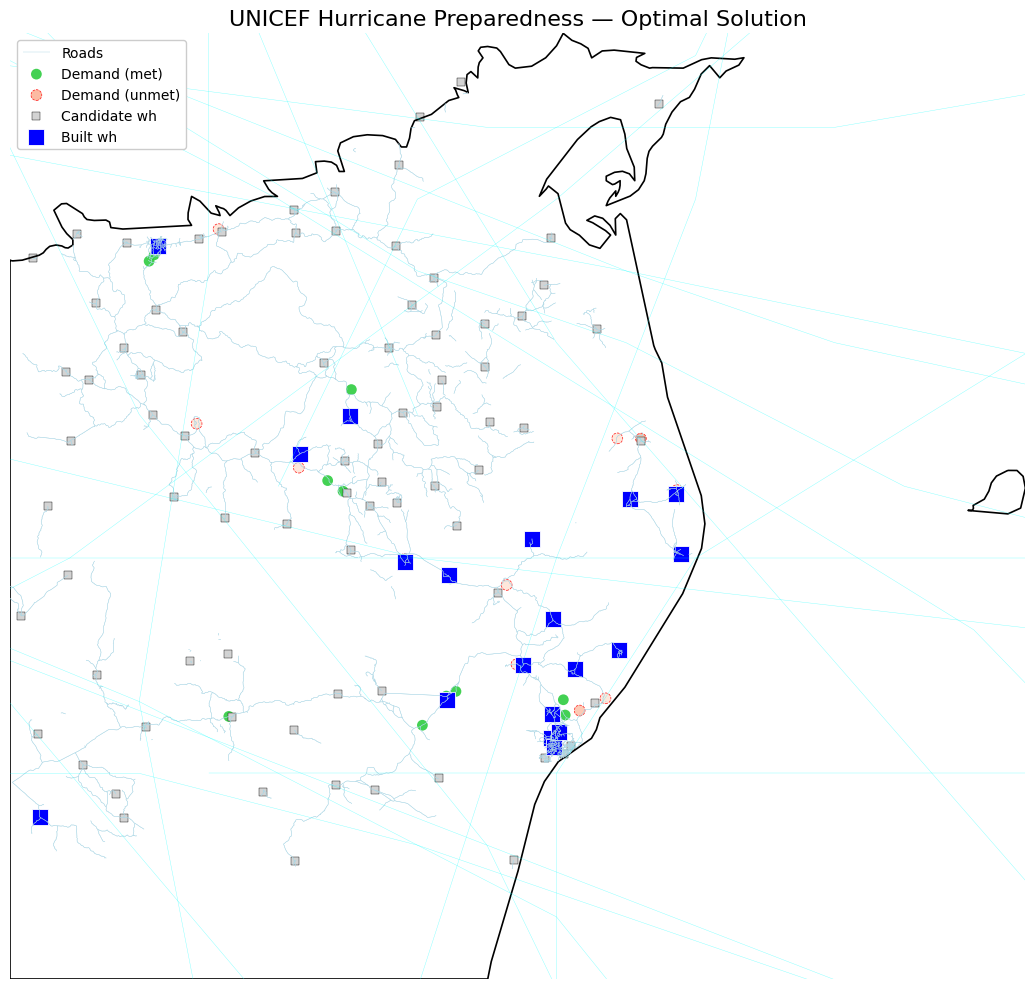

In [42]:
plot_solution_map(G_hot, kept_scenarios,
                  ware_gdf, ware_gdf,
                  dem_gdf, gdf_nic_clipped,
                  solution="optimal")      # or "baseline"

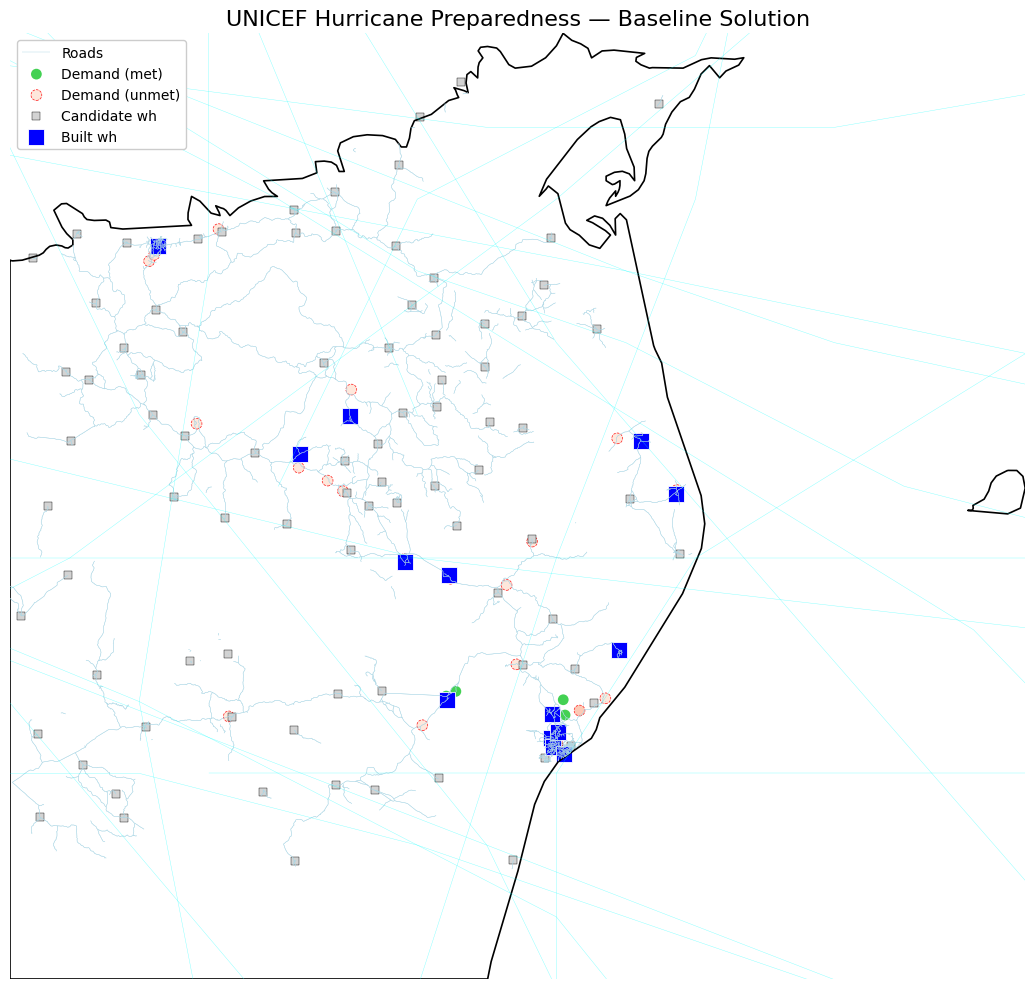

In [43]:
plot_solution_map(G_hot, kept_scenarios,
                  ware_gdf, ware_gdf,
                  dem_gdf, gdf_nic_clipped,
                  solution="baseline")      # or "baseline"

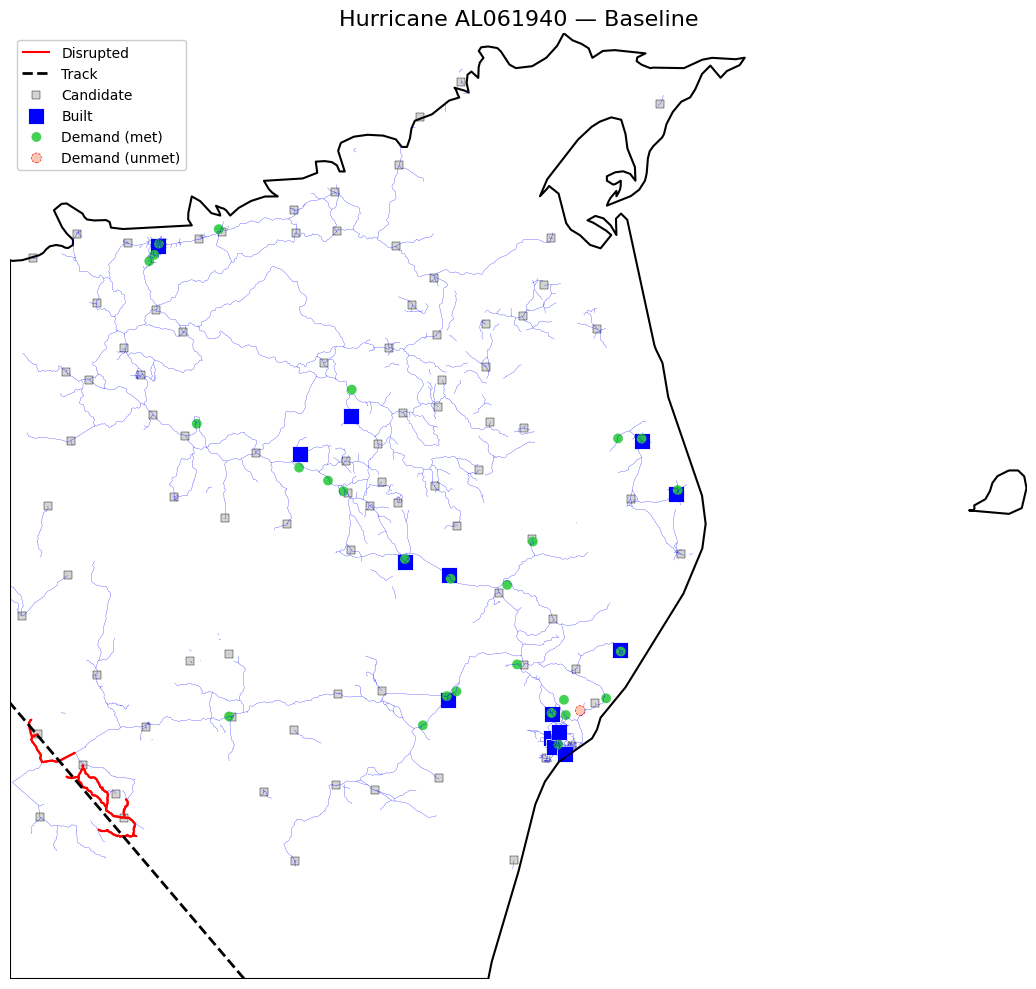

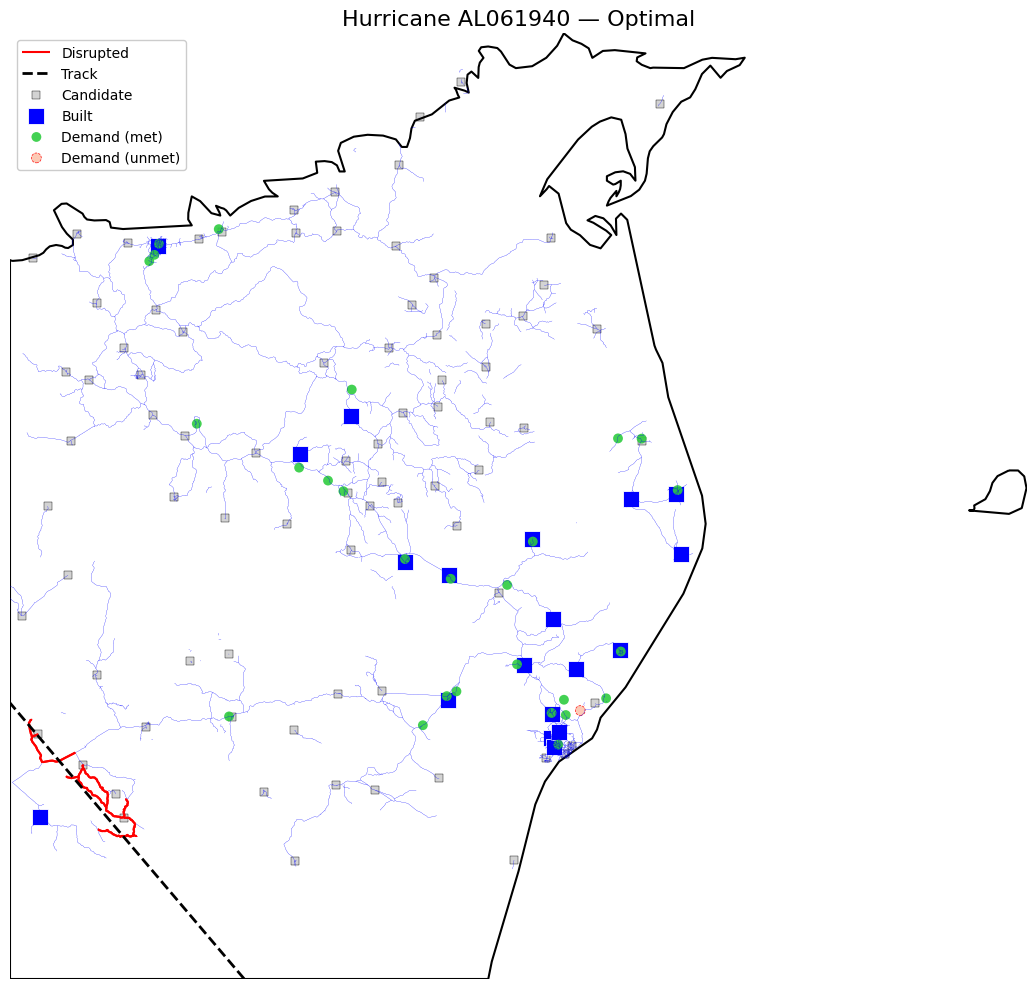

In [44]:
plot_hurricane_disruption_zoomed(
    G_hot, "AL061940", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="baseline")

plot_hurricane_disruption_zoomed(
    G_hot, "AL061940", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="optimal")

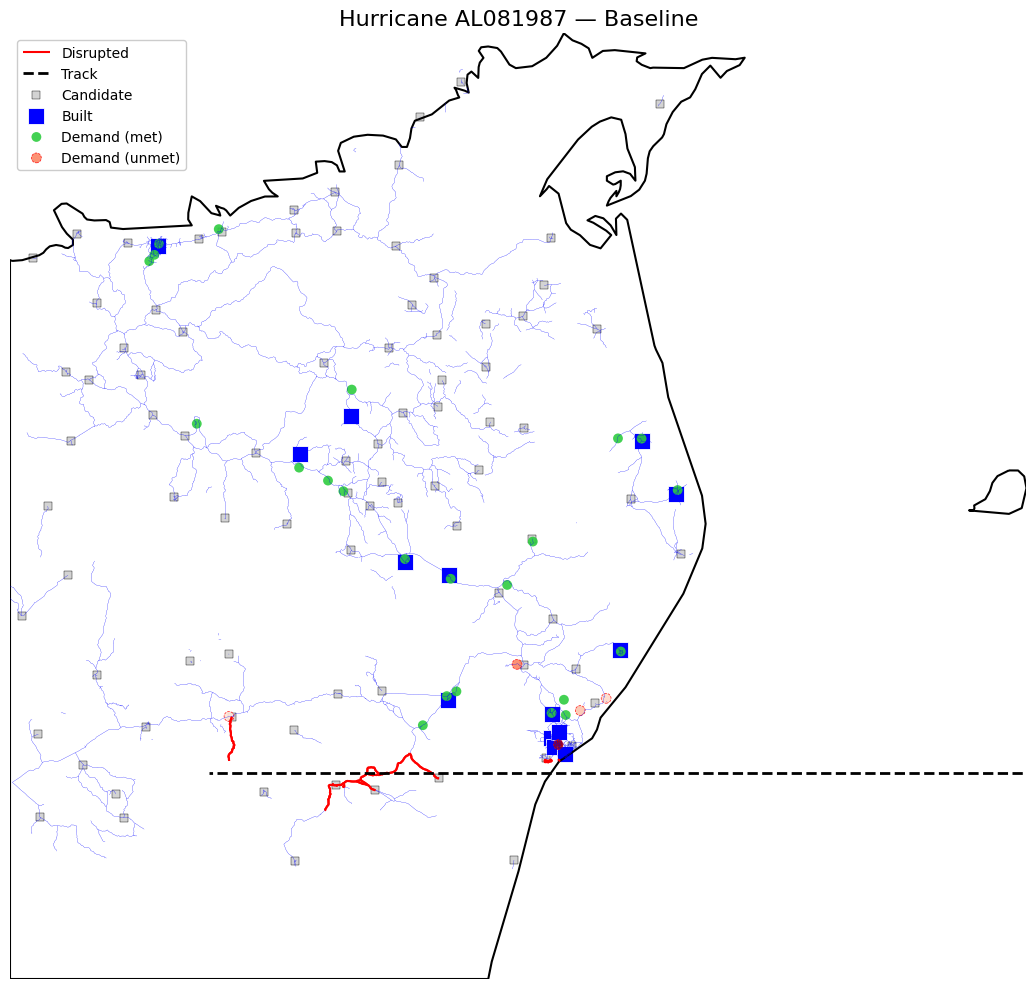

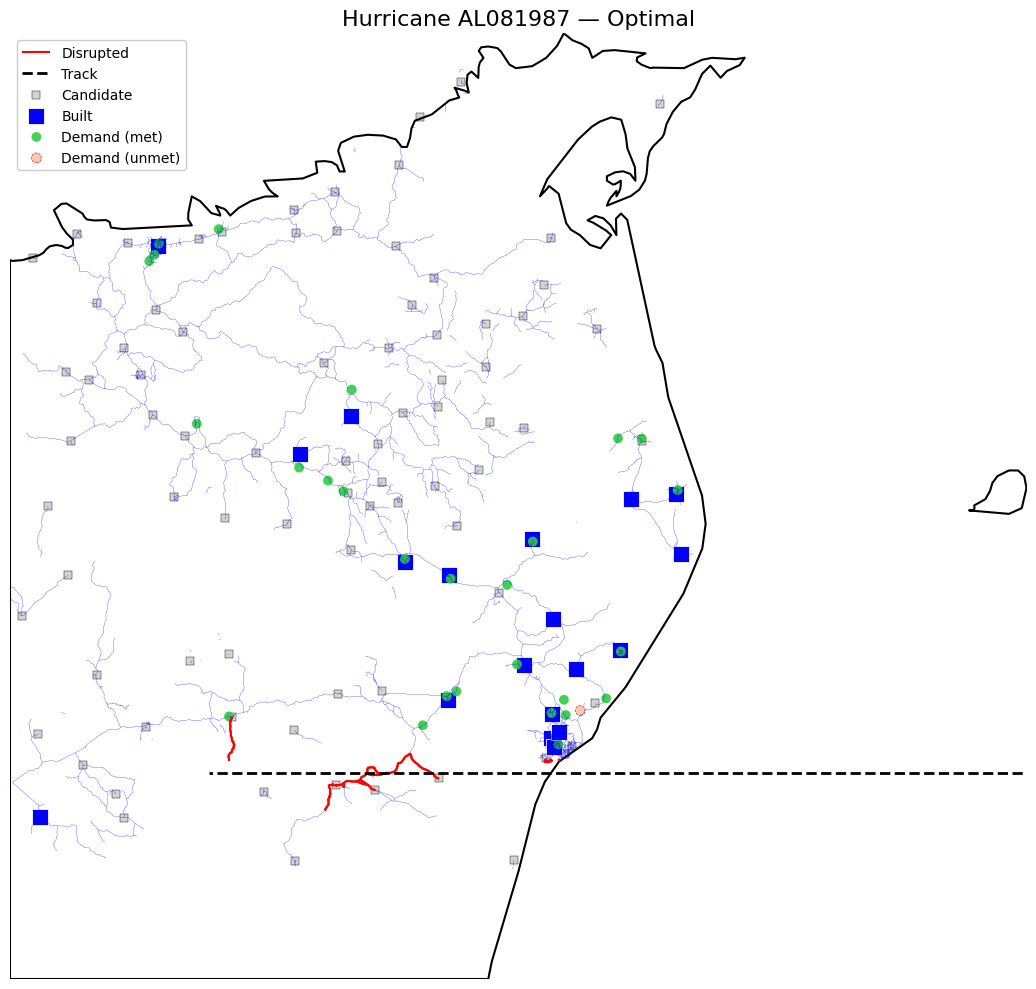

In [45]:
plot_hurricane_disruption_zoomed(
    G_hot, "AL081987", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="baseline")

plot_hurricane_disruption_zoomed(
    G_hot, "AL081987", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="optimal")

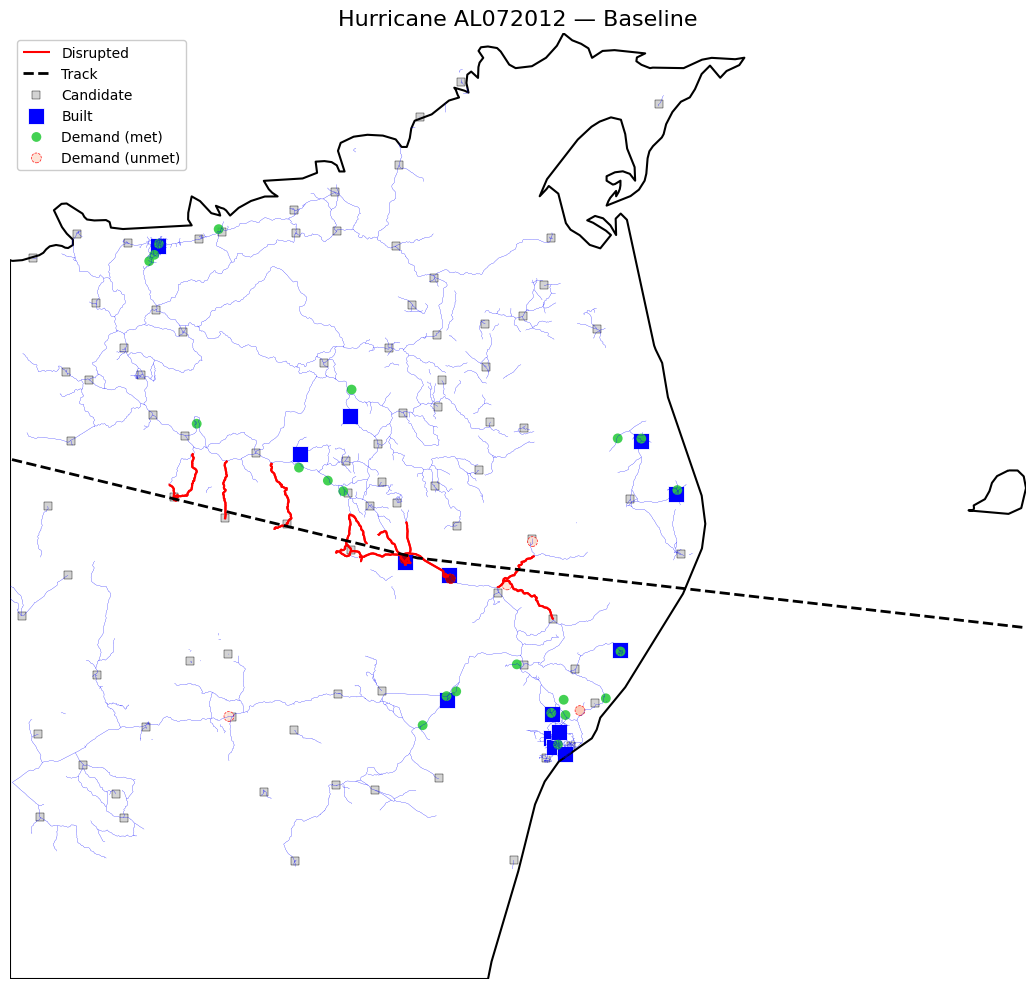

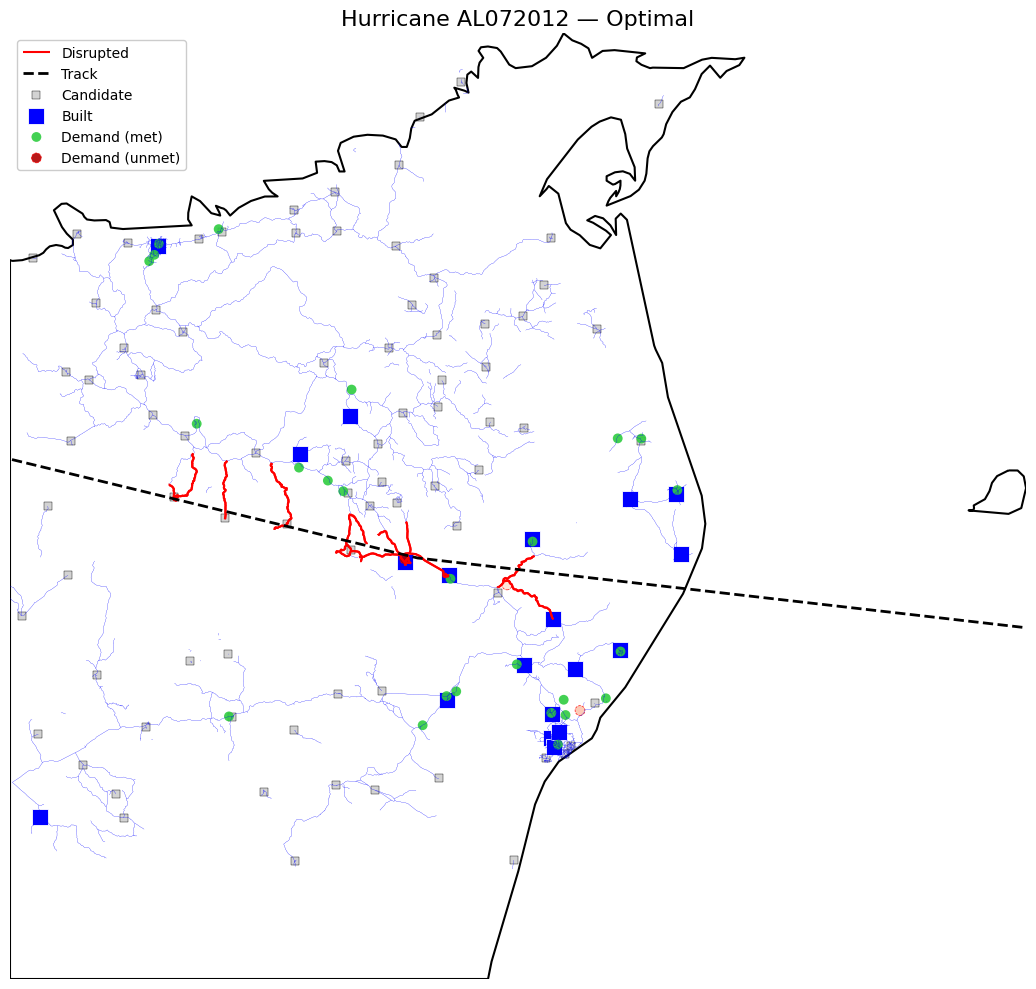

In [46]:
plot_hurricane_disruption_zoomed(
    G_hot, "AL072012", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="baseline")

plot_hurricane_disruption_zoomed(
    G_hot, "AL072012", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="optimal")

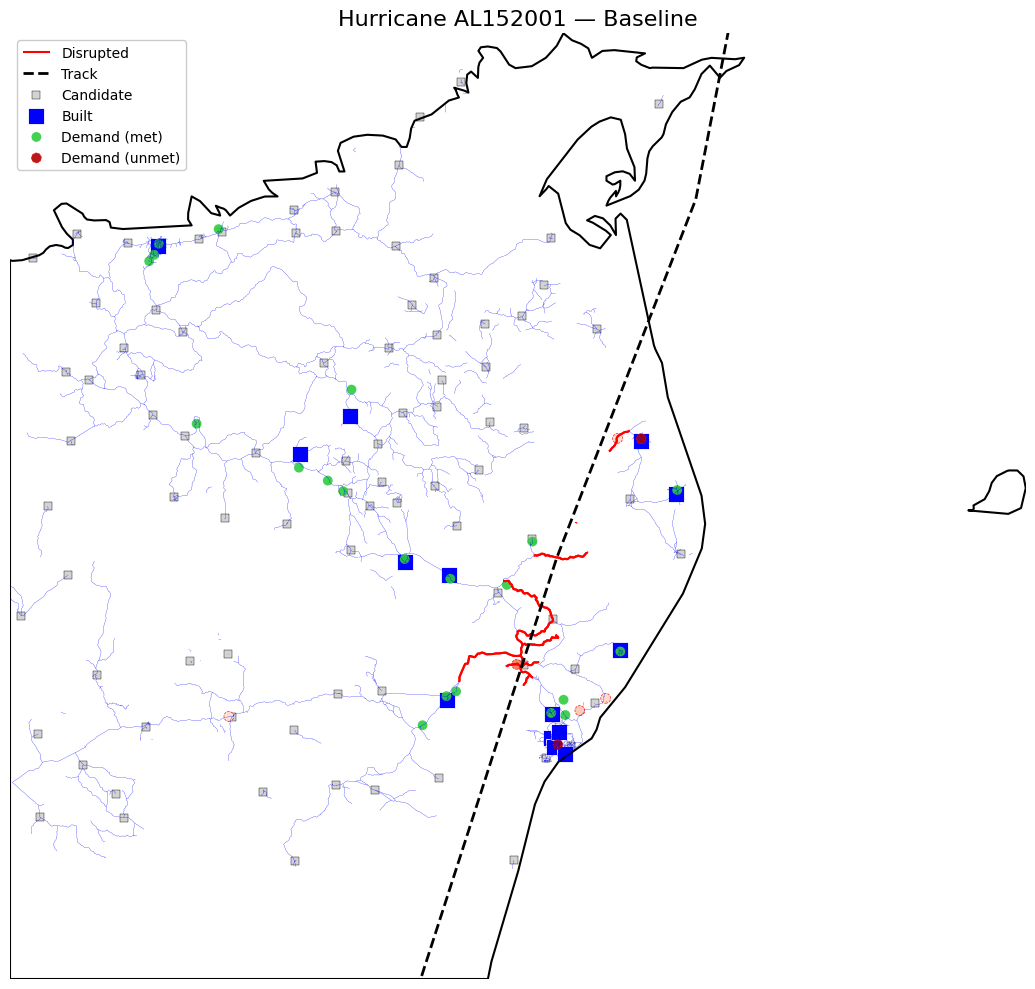

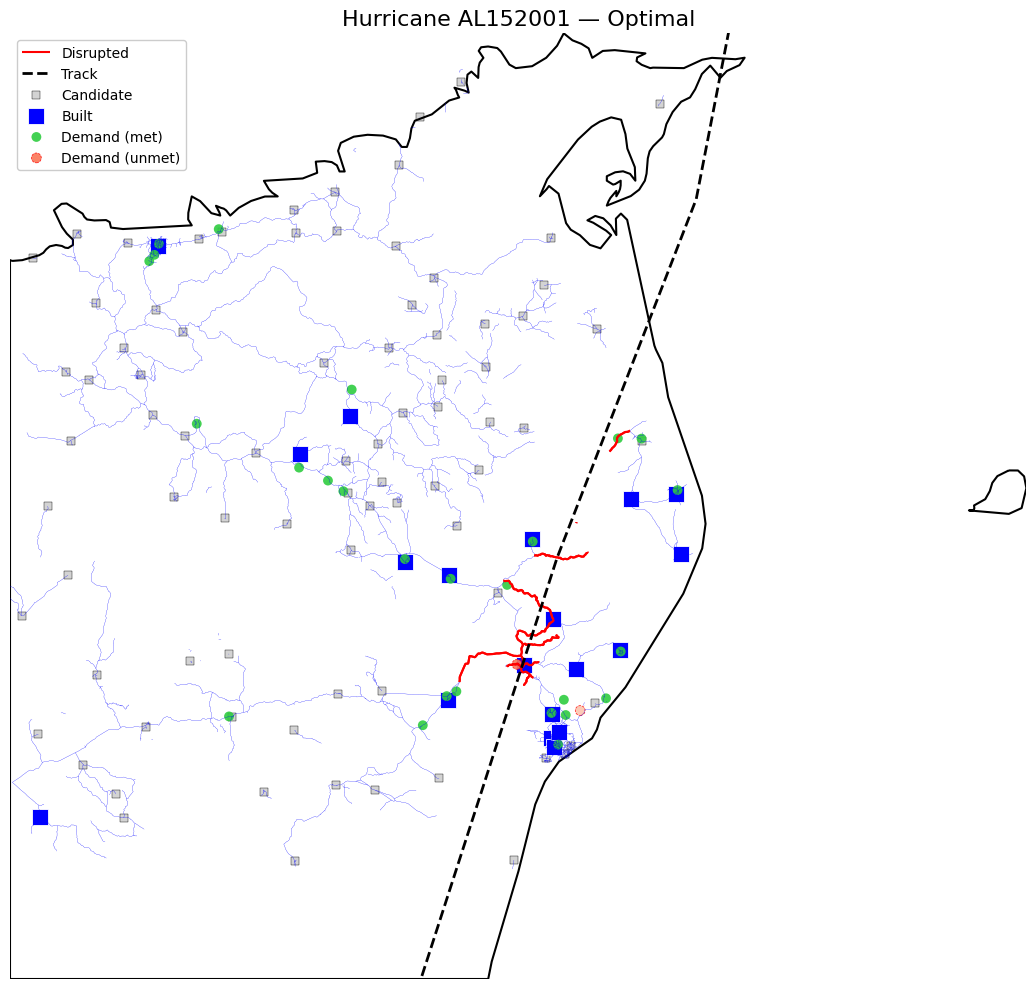

In [49]:
plot_hurricane_disruption_zoomed(
    G_hot, "AL152001", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="baseline")

plot_hurricane_disruption_zoomed(
    G_hot, "AL152001", gdf_nic_clipped,
    kept_scenarios, ware_gdf, ware_gdf,
    dem_gdf, buffer_km=2.0, solution="optimal")

## Convergence plot

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


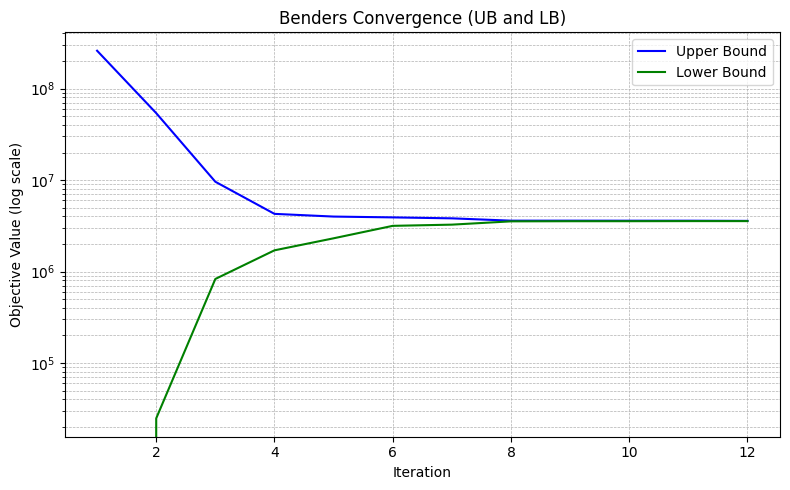

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the convergence history
df = pd.read_csv("output/convergence.csv")

# Plot UB and LB with log scale on the gap
plt.figure(figsize=(8, 5))
plt.plot(df["iter"], df["UB"], label="Upper Bound", color="blue")
plt.plot(df["iter"], df["LB"], label="Lower Bound", color="green")
plt.yscale("log")  # Apply log scale to y-axis if appropriate for gaps

# Add plot labels and legend
plt.xlabel("Iteration")
plt.ylabel("Objective Value (log scale)")
plt.title("Benders Convergence (UB and LB)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Save and show the figure
plt.savefig("output/convergence_plot_logscale.png", dpi=300)
plt.show()

In [14]:
curr = set(["PAS",
"BSC",
"MAN",
"MAG",
"ABL",  
"AGM",  
"BAC",  
"BHP",  
"CFS",  
"DLA",  
"EML",  
"FMO",  
"GOR",  
"HYS",  
"IPT",  
"LAF",  
"MRS",  
"NWH",  
"SAN",  ])

In [15]:
avail = set(['ABL', 'ACP', 'ADO', 'AGM', 'AGO', 'ALP', 'ANG', 'APL', 'ARV', 'ASP', 'AVC', 'AVM', 'BAC', 'BAI', 'BAK', 'BAR', 'BAW', 'BBR', 'BBS', 'BC3', 'BCH', 'BCW', 'BEL', 'BFS', 'BHP', 'BLA2', 'BLC', 'BLY', 'BOM', 'BOR', 'BRE', 'BTL2', 'BTP', 'BUE', 'CAC', 'CAR', 'CBC', 'CCA', 'CCC', 'CCK', 'CCT', 'CDD', 'CDM', 'CFD', 'CFS', 'CFT', 'CGO', 'CHF', 'CHI', 'CHK', 'CHL', 'CHN', 'CHR', 'CIA', 'CJM', 'CJV2', 'CKP', 'CLC', 'CLI2', 'CLO', 'CLT', 'COA', 'COK2', 'CPO', 'CPT2', 'CRF', 'CRG', 'CRN', 'CRR', 'CRY', 'CSH', 'CSL', 'CTC', 'CTW', 'CVW', 'CWC', 'CWP', 'CYP', 'CZN', 'DAN', 'DAW', 'DEC', 'DEV', 'DGR', 'DJJ', 'DJJB', 'DLA', 'DNR', 'DPP', 'DRE', 'DSC', 'DSN5', 'DSN6', 'DSN8', 'DTC', 'DTP', 'DZA', 'EDW2', 'ELO', 'ELS2', 'EML', 'EMS', 'EOC', 'ERR', 'ESI2', 'FDR', 'FHO', 'FIG', 'FMO', 'FMP', 'FON', 'FOX2', 'FRK', 'FRM', 'FSR', 'FUL', 'FUR', 'GATR', 'GCC', 'GDF', 'GFF', 'GFS', 'GLA', 'GMA', 'GMR', 'GOR', 'GOU', 'GR2', 'GRA', 'GSA', 'GSC', 'GVR', 'HAR', 'HAY', 'HDH', 'HEC', 'HHL', 'HIW', 'HLL', 'HLN', 'HMT2', 'HOL', 'HRV', 'HYS', 'IDO', 'IDQ', 'IDY', 'IKP', 'IMP', 'IPT', 'IRG5', 'IRM', 'ISA', 'IVY', 'JEM', 'JNH2', 'JPLS', 'JRC2', 'JTH', 'JVA', 'KIK', 'KML', 'KRV1', 'KRV3', 'KYV', 'LAF', 'LAT', 'LBW1', 'LBW2', 'LCG', 'LCP', 'LDF', 'LDR', 'LEO', 'LFP', 'LGB', 'LJR', 'LKH', 'LLS', 'LMH', 'LMR2', 'LMS', 'LMY', 'LOC', 'LPC', 'LRL', 'LRR2', 'LTP', 'LUC2', 'LUG', 'LUS', 'LVO', 'LVY', 'LYP', 'MAG', 'MAN', 'MCT', 'MES', 'MGE', 'MIK', 'MIKB', 'MIS', 'MLAC', 'MLS', 'MMC', 'MNO', 'MOP', 'MOR', 'MPI', 'MPM', 'MPP', 'MRS', 'MSC', 'MSJ', 'MTA', 'MTG', 'MTP', 'MUR', 'MWC', 'NBS', 'NCH', 'NEE2', 'NEN', 'NJQ', 'NOT', 'NPN', 'NSS2', 'NWH', 'OAT', 'OCP', 'OGC', 'OLI', 'OLP', 'OSI', 'PALA', 'PASC', 'PDE', 'PDM', 'PDR', 'PDU', 'PDW', 'PEM', 'PER', 'PGA', 'PHL', 'PLM', 'PLR', 'PLS', 'PMD', 'POB2', 'POP', 'POR', 'PSD', 'PSR', 'PTD', 'PUT', 'PZA', 'Q0000', 'Q0001', 'Q0002', 'Q0005', 'Q0008', 'Q0009', 'Q0010', 'Q0011', 'Q0013', 'Q0014', 'Q0015', 'Q0017', 'Q0018', 'Q0020', 'Q0022', 'Q0023', 'Q0024', 'Q0025', 'Q0027', 'Q0030', 'Q0031', 'Q0032', 'Q0033', 'Q0034', 'Q0035', 'Q0037', 'Q0038', 'Q0039', 'Q0040', 'Q0041', 'Q0042', 'Q0045', 'Q0046', 'Q0048', 'Q0049', 'Q0050', 'Q0055', 'Q0056', 'Q0057', 'Q0058', 'Q0059', 'Q0060', 'Q0061', 'Q0062', 'Q0064', 'Q0065', 'Q0066', 'Q0067', 'Q0068', 'Q0069', 'Q0070', 'Q0071', 'Q0072', 'Q0073', 'Q0074', 'Q0075', 'Q0077', 'Q0078', 'Q0079', 'Q0081', 'Q0082', 'QAD', 'QLC', 'QSD01', 'QSD02', 'QSD03', 'QSD04', 'QSD05', 'QSD06', 'QUG', 'RAG', 'RCR', 'RCT', 'RCU', 'RFR', 'RHC2', 'RHR', 'RIN', 'RINB', 'RIO', 'RKMO', 'RMM', 'RPK', 'RPV', 'RRC', 'RRX', 'RSB', 'RSI', 'RSP', 'RSS', 'RUN', 'RUS', 'RVR', 'RXH', 'RYS', 'SAL', 'SAN', 'SBB2', 'SBC', 'SBI', 'SBPX', 'SCI2', 'SCZ2', 'SDD', 'SDG', 'SDR', 'SES', 'SEV', 'SGL', 'SHO', 'SHR', 'SHU', 'SIL', 'SLA', 'SLB', 'SLH', 'SLM', 'SLR', 'SLV', 'SMF2', 'SMI', 'SMM', 'SMR', 'SMT', 'SMV', 'SMW', 'SNCC', 'SNO', 'SNR', 'SOC', 'SOL2', 'SPF', 'SPG2', 'SQC', 'SRA', 'SRI', 'SRN', 'SRT', 'SS3', 'SSS', 'STC', 'STG', 'STS', 'SUN', 'SVD', 'SWP', 'SWS', 'SYN', 'SYP', 'TA2', 'TEH', 'TEJ', 'TER2', 'TFT', 'THC', 'THM', 'TIN', 'TJR', 'TOR', 'TOW2', 'TPO', 'TUQ', 'USB', 'USC', 'VCP', 'VCS', 'VDJ', 'VES', 'VLO', 'VLY', 'VOG', 'VTV', 'WAS2', 'WBM', 'WBP', 'WBS', 'WCS2', 'WES', 'WGR', 'WHF', 'WLH2', 'WLS2', 'WLT', 'WMD', 'WMF', 'WNM', 'WNS', 'WOR', 'WRC2', 'WRV2', 'WSS', 'WTT2', 'WVP2', 'WWC', 'WWF', 'XTL2', 'YEG2', 'YUC', 'YUH2'])

In [16]:
len(curr - avail)

2

In [17]:
curr & avail

{'ABL',
 'AGM',
 'BAC',
 'BHP',
 'CFS',
 'DLA',
 'EML',
 'FMO',
 'GOR',
 'HYS',
 'IPT',
 'LAF',
 'MAG',
 'MAN',
 'MRS',
 'NWH',
 'SAN'}

In [22]:
import random

remaining = list(avail - curr)
selected = random.sample(remaining, 25)

print(selected)

['PDW', 'PTD', 'LVY', 'WRC2', 'BTP', 'BAI', 'SYN', 'JVA', 'Q0072', 'CPO', 'KRV3', 'SES', 'PLR', 'DGR', 'SDG', 'YUH2', 'BTL2', 'CRR', 'STG', 'FRM', 'RRX', 'CWC', 'JRC2', 'CYP', 'CLI2']


In [ ]:
- ABL  # early “A” cluster
- AGM  # mid-“A”
- BAC  # early “B”
- BHP  # mid-“B”
- CFS  # early “C”
- DLA  # “D” block
- EML  # “E”
- FMO  # “F”
- GOR  # “G”
- HYS  # “H”
- IPT  # “I”
- LAF  # “L”
- MRS  # “M”
- NWH  # “N”
- SAN  # “S”